# BA optimization

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


파이썬 코드를 실행하기 전에 항상 모든 모듈을 reload 하도록 강제 설정

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import selfies as sf
import torch
import time
from tqdm import tqdm, trange
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [4]:
## Inter-op parallelism
torch.set_num_interop_threads(4)
torch.get_num_interop_threads()
## Intra-op parallelism
torch.set_num_threads(4)
torch.get_num_threads()

4

In [5]:
class GPUCONFIGS:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.use_cuda else 'cpu')
        if self.use_cuda: torch.cuda.set_device(self.device)
        
gpuconfigs = GPUCONFIGS()
print(torch.cuda.current_device())

0


In [6]:
REBADD_LIB_PATH = os.path.abspath(os.pardir)
if REBADD_LIB_PATH not in sys.path:
    sys.path = [REBADD_LIB_PATH] + sys.path

from rebadd.stackVAE import StackAugmentedVAE
from rebadd.datautils import GeneratorData
from rebadd.reinforce import REINFORCE_SCST_OFFPOLICY as REINFORCE

# 1. Generator

## 1-1) Data loading for generators

In [7]:
class DATACONFIGS:
    def __init__(self):
        ## input
        self.input_dir = os.path.join('processed_data', 'zinc15')
        self.train_data_path = os.path.join(self.input_dir, 'fragments_list.pkl')
        self.vocab_data_path = os.path.join(self.input_dir, 'vocabulary.csv')
        ## output
        self.output_dir = os.path.join('outputs_2_optimize_ReBADD', 'zinc15')
        assert os.path.exists(self.output_dir)

dataconfigs = DATACONFIGS()

In [8]:
gen_data = GeneratorData(pickle_data_path=dataconfigs.train_data_path,
                         vocabulary_path=dataconfigs.vocab_data_path,
                         use_cuda=gpuconfigs.use_cuda)

print(f"Number of training samples: {len(gen_data.data)}")
print(f"Number of vocabulary: {len(gen_data.vocabs)}")
print(f"Maximum of seqlen: {gen_data.max_seqlen}")

Number of training samples: 600116
Number of vocabulary: 49
Maximum of seqlen: 156


## 1-2) Pretrained generators

In [9]:
kwargs_generator = {"input_size"         : gen_data.n_characters,
                    "output_size"        : gen_data.n_characters,
                    "max_seqlen"         : 156,
                    "hidden_size"        : 256,
                    "latent_size"        : 64,
                    "n_layers"           : 4,
                    "has_stack"          : True,
                    "stack_width"        : 256,
                    "stack_depth"        : 20,
                    "lr"                 : 1e-4,
                    "use_cuda"           : gpuconfigs.use_cuda,
                    "device"             : gpuconfigs.device,
                    "optimizer_instance" : torch.optim.RMSprop}

In [10]:
my_generator_after  = StackAugmentedVAE(**kwargs_generator)

In [11]:
class CKPTCONFIGS:
    def __init__(self):
        self.model_path = os.path.join('outputs_1_pretraining_ReBADD', 'zinc15', 'checkpoint.pth')
        
ckptconfigs = CKPTCONFIGS()

In [12]:
my_generator_after.load_model(ckptconfigs.model_path)

# 2. Reinforcement learning

In [13]:
from ReBADD_config import Reward_bcl2_bclxl_bclw as Reward

## 2-1) RL design

In [14]:
my_reward_ft = Reward(use_cuda=gpuconfigs.use_cuda, device=gpuconfigs.device)

[DEBUG] BA(navitoclax,P10415) = 9.746 (GT:9.745)
[DEBUG] BA(navitoclax,Q07817) = 7.525 (GT:7.524)
[DEBUG] BA(navitoclax,Q92843) = 6.598 (GT:6.597)
[DEBUG] SA(navitoclax) = 4.131 (GT:4.131)


In [15]:
ReBADD = REINFORCE(data=gen_data, generator=my_generator_after, reward_ft=my_reward_ft)

## 2-2) Training

In [16]:
model_path = os.path.join(dataconfigs.output_dir, 'checkpoint.pth')
losses_path = os.path.join(dataconfigs.output_dir, 'losses.csv')
plot_path = os.path.join(dataconfigs.output_dir, "plots_reward_losses.pdf")

In [17]:
def SMILES_generate(generator, n_to_generate, gen_data):
    generated = []
    for i in trange(n_to_generate):
        z = generator.sample_latent_vectors()
        sel = generator.evaluate(gen_data, z=z)
        sel = sel.replace(gen_data.start_token, "").replace(gen_data.end_token, "")
        smi = sf.decoder(sel)
        generated.append(smi)
    return generated

In [18]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [19]:
def show_reward_loss(rewards, losses, figsize=(8,2.5), filepath=None):
    fig, ax = plt.subplots(1,2,figsize=figsize)
    
    ax[0].plot(rewards)
    ax[0].set_xlabel('Training iteration')
    ax[0].set_ylabel('Average reward')
    ax[1].plot(rl_losses, 'r')
    ax[1].set_xlabel('Training iteration')
    ax[1].set_ylabel('Loss')
    
    plt.tight_layout()
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)

In [20]:
def write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, filepath):
    df_history = pd.DataFrame({"REWARD":tr_rewards,
                               "LOSS":rl_losses,
                               "LOSS_RECONST":reconst_losses,
                               "LOSS_ENTROPY":entropy_losses,
                               "BA_A":ba_A_list,
                               "BA_B":ba_B_list,
                               "BA_C":ba_C_list,
                               "EXEC_TIME":execution_times})
    df_history.to_csv(filepath, index=False)
    return df_history

In [21]:
# Setting up some parameters for the experiment
n_iterations = 500
checkpoint_stepsize = 10
behavior_stepsize = 20

[0001] rl_loss: 0.247	reconst_loss: 0.213	entropy_loss: 0.034	reward: 0.545	tau: 0.302	(78.911 sec)
[0002] rl_loss: 0.156	reconst_loss: 0.122	entropy_loss: 0.034	reward: 0.366	tau: 0.302	(157.549 sec)
[0003] rl_loss: 0.248	reconst_loss: 0.213	entropy_loss: 0.035	reward: 0.515	tau: 0.302	(236.838 sec)
[0004] rl_loss: 0.388	reconst_loss: 0.354	entropy_loss: 0.034	reward: 0.687	tau: 0.306	(319.122 sec)
[0005] rl_loss: 0.260	reconst_loss: 0.225	entropy_loss: 0.035	reward: 0.572	tau: 0.306	(398.298 sec)
[0006] rl_loss: 0.294	reconst_loss: 0.259	entropy_loss: 0.035	reward: 0.611	tau: 0.306	(478.099 sec)
[0007] rl_loss: 0.366	reconst_loss: 0.331	entropy_loss: 0.035	reward: 0.620	tau: 0.306	(559.056 sec)
[0008] rl_loss: 0.304	reconst_loss: 0.269	entropy_loss: 0.035	reward: 0.614	tau: 0.306	(641.179 sec)
[0009] rl_loss: 0.231	reconst_loss: 0.195	entropy_loss: 0.036	reward: 0.508	tau: 0.306	(721.160 sec)
[0010] rl_loss: 0.462	reconst_loss: 0.427	entropy_loss: 0.035	reward: 0.713	tau: 0.310	(803.

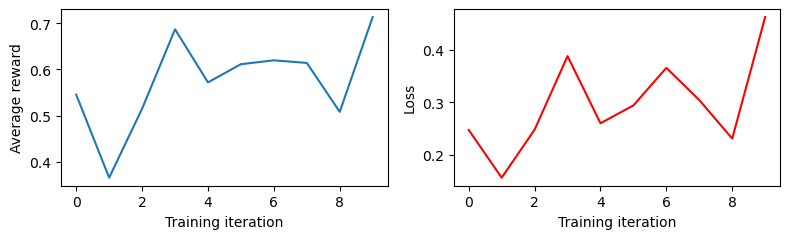

100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Sample trajectories: 100
[8.011, 7.895, 6.959, 1.330, 1.164, 0.653]    CN(C=CC=C(N1C(C)=C2CC3C(C4=CC=CC=N4)NC(=S)N3C5=CC=C(Cl)C=C5)C2)SC6=CC=CC=C6C=C1
[5.677, 5.926, 5.631, 0.026, 0.042, 0.063]    CCCOC(=O)C1S(=O)(=O)N(N1CC(=O)NC2=CC=C(Cl)C=C2C(=O)C=CC=CC3=C)CCCC3
[6.310, 6.288, 6.963, 0.088, 0.085, 0.657]    C1C=CC=CC21C(=O)NC=CC=C(Cl)C(NC(=S)NC(=O)C3=CC=CC=C3)=C2CC4=CC=CC=C4NCCCCC
[5.274, 5.049, 4.509, 0.012, 0.007, 0.007]    CCOC(=O)C=C(C1=CC=NC=C1)N(C(=O)C(C(C)C)NC(=O)NC(=O)OCC)CCOC=O
[6.142, 6.413, 6.020, 0.064, 0.108, 0.132]    COC1=CC=CC=C1C=NC(SC2=NC=3SC=C(C=3C(=O)N2CC4=CC=CO4)CC)(C)N5CCOCC5C=O
[5.389, 5.098, 5.458, 0.015, 0.008, 0.045]    COC=CC(C=CSC(=O)N(CC(=O)NC1=CC=CC(SC)=C1C)C=O)=N
[5.734, 5.296, 4.926, 0.029, 0.012, 0.016]    C1COC2=CC(C=C3C(=N)N4C(=NC3=O)SN=C4S(=O)=O)C5=CC=CC=C5C(C)C2C=C1OCC
[6.908, 6.231, 6.465, 0.267, 0.076, 0.295]    CC1=CC=CC(=C1)C2C=CCC2C3(C(=O)C4=CC5=CC=C4C3=O)CCCCC(C6S7C[NH1]C=CC7=O)=NN56
[5.078, 4.432, 4.874, 0.008, 0.002, 0.014]    CCC(C)CNC(=O

[6.829, 6.431, 6.061, 0.232, 0.112, 0.142]    CCC1CCCC(OCCCCC)(C)NC(=O)NCCOC(NC(=O)C2=CC=C3C(=C2)OCCO3)CCNC(=O)C4=CSC1=N4
[6.129, 6.425, 5.685, 0.062, 0.110, 0.070]    CCCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC=C2)C(=O)CCCN(C3=CC=C4C(=C3)OCCO4)S(=O)(=O)CC
[5.983, 5.505, 5.873, 0.047, 0.018, 0.100]    CCCCCCOC(=O)CC(C(=O)NC1=CC=CC(Cl)=C1F)NC2=CC=CC(Br)=C2N3CCCC3
[6.933, 5.044, 5.533, 0.279, 0.007, 0.052]    CCCCNC(=O)C(C)N(C1C2=C3C=C(Cl)C=C2)C(=O)CN(C=CC=C(OCC4=CC=CC=C4)COCC5=CC=CC=C5)CC13
[4.772, 4.423, 5.310, 0.004, 0.002, 0.033]    C1C[NH1]C=CC=C(NC1=O)CC(=O)O
[5.578, 5.522, 5.073, 0.021, 0.019, 0.021]    C12C=CC=C(S(=O)(=O)N1CC(=O)NC=NN=C(C3=CC=CC=C3)OC)CC(=O)C(C)=C2C(OC(C)=O)C(OC(C)=O)COC(C)=O
[4.177, 3.563, 4.544, 0.001, 0.000, 0.007]    C1C=NN(C2=CC=CC(C(F)(F)F)=C2)O1
[7.794, 6.792, 5.612, 1.030, 0.217, 0.060]    COC=CC(OC)=CCC(=O)CCC(=O)N(C1=CC=C(Cl)C(Cl)=C1)C(=S)N=CONC2=CC=C(Cl)C=C2Cl
[6.529, 6.494, 7.030, 0.134, 0.125, 0.724]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=CC=C2OC)

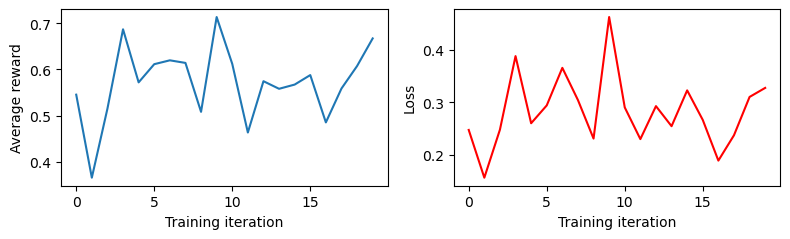

100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Sample trajectories: 100
[5.383, 4.807, 5.058, 0.014, 0.005, 0.020]    CCCCNC(SCC(=O)NC1=CC(S(=O)(=O)N2CCCC2)=CC=C1O)C3=CC=C(Cl)C=C3Cl
[5.305, 4.698, 5.217, 0.012, 0.004, 0.028]    CCOC=CC=CCCS=1C(NC(=O)C(C)(C)CCOCCC(=O)O)C=C(C)N=1
[5.846, 5.186, 5.292, 0.036, 0.010, 0.032]    C1OC=CC=CN(CC(=O)NC2=CC=C(S(=O)(=O)NC3=NC=CC(C)=N3)C=C2)C4=CC(Br)=CC=C4O1
[5.418, 5.428, 5.308, 0.015, 0.016, 0.033]    C1OCC(=O)NC=CC=C1C(=O)NNC(=O)C2SC3=CC(Cl)=CC=C3N2CC4=CC=CC=C4F
[6.788, 6.231, 5.390, 0.216, 0.076, 0.039]    C1C2C=CC=C(OCC3OC=CC=CC(C=C4SC(=S)N(C5=CC=C(Cl)C(Cl)=C5)C4=O)=C3C2)OC=C1
[6.961, 6.165, 5.207, 0.293, 0.067, 0.027]    CC=CC=CC(N(CC1=CC=CC=C1)C(=O)NC(C)CSC=NC(C)=CCC2=CC(Cl)=C(C)C=C2O)=N
[6.378, 5.684, 5.534, 0.101, 0.026, 0.052]    N1S(=O)(=O)C=CC=C(CCC(=O)N(CC2=CC=C(Cl)C=C2)C(C)C(=O)NCC(C)C)C=C1
[4.799, 4.127, 4.300, 0.004, 0.001, 0.005]    CS(=O)(=O)NCC(C1=CC2=CS1)N3CCCC3C(=O)NC(C(=O)O)C(O)C(O)C2O
[6.481, 5.644, 6.269, 0.123, 0.024, 0.208]    CCC=CC=C1CC(=O)C(C2=CC=CC=C2)N(C3=CC=CC(Cl

[6.913, 7.227, 6.518, 0.269, 0.457, 0.323]    COC=CC=C(C(C(=O)NC1C2CCC1)N(CC3=CC=CC=C34)C(=O)CNC(=O)C=CC5=CC=CS5)C(=O)NC4C2
[5.472, 5.077, 5.281, 0.017, 0.008, 0.032]    CC1=C(Cl)C=CC=C1NC(=O)NC(=O)C(=C2C=C(OCC3=CC=C(F)C=C3)C=CC4=CC=CC=C24)C=O
[6.687, 6.365, 5.960, 0.180, 0.098, 0.118]    CC=CC(C)=C(C)CS(=O)(=O)NCCCC1C(C(=O)N(CC2=CC=C(C(C)(C)C)C=C2)NC(=S)NC1=CC3=CCBr)=CC=C3O
[6.402, 6.345, 5.175, 0.106, 0.095, 0.026]    CCOC(=O)C1=C(C2=CC=CC=C2)N=C3SC(=CC=4C=C(C)N(C5=CC(C(F)(F)F)=CC=C5)O)CC=4C(=O)N3C1C6=CC=CC=C6
[7.025, 7.311, 6.667, 0.327, 0.522, 0.415]    CCOC(=O)C1=C(C)N=C2SC=CN2C1C3=CC=C(OCC4=CC=C([N+1](=O)[O-1])C=C4)C=C3C5=CC=C(Cl)C=C5
[6.276, 5.826, 6.633, 0.083, 0.035, 0.392]    C1CC(C(=O)NC)N(CC2=CC=C(Cl)C=C2Cl)C(=O)COC3=CC(C)=CC(C)=C3N=C1
[5.910, 5.185, 5.403, 0.041, 0.010, 0.040]    CCOC(=O)COC=CC(Br)=C(C=C1SC(=O)N(CC2=CC=C(Cl)C=C2Cl)C1=O)C3=CC=CC=C3
[5.905, 5.989, 5.709, 0.040, 0.048, 0.073]    COC(=O)C=C(C)N(C1=CC=C(F)C(Cl)=C1)C(=S)NC(=S)NC2=CC=C(Br)C=C2
[6.250, 5.795, 6.08

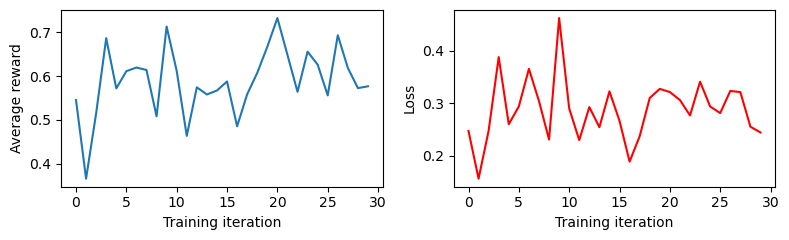

100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Sample trajectories: 100
[5.839, 5.906, 6.402, 0.035, 0.040, 0.264]    COC=CC=C(CC1=CC(OCC)=C(OCC)C=C1C(=O)NCOC2=CC=C(Br)C=C2CC3=CC=CNC(C)=O)C=C3
[8.485, 7.367, 6.965, 2.100, 0.569, 0.658]    CC1C=NSC(S(=O)(=O)CCC(=O)NC2=CC=C(C=C2)OCCNC(=O)C(C(C)C)CCCCCNC)(O)C(CC3=CC=CC=N3)NC(=O)C1
[4.602, 4.979, 4.623, 0.003, 0.006, 0.009]    CC=CC=C(S(=O)(=O)N(CC(=O)NC1=CC=C2C(=C1)OCCO2)C=O)NOC
[7.043, 5.939, 6.283, 0.337, 0.043, 0.214]    COC1=CC=C(S(=O)(=O)N2CCCCC2)C=C1CC(=O)NCC3=CC=C(S(=O)(=O)NC4CC4)C=C3
[6.716, 6.843, 6.722, 0.190, 0.238, 0.453]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2)C(=O)CN(C3=CC(Cl)=CC=C3OC)S(C)(=O)=O
[5.326, 4.799, 4.811, 0.013, 0.004, 0.012]    C1OC=CC=C(C(=O)NC(=S)NC2=CC=CC=C2C(F)(F)CF)CC(C)=C1
[5.738, 4.653, 5.162, 0.029, 0.003, 0.025]    COC1=CC=CC=C1OCCCC2N(C(=O)CC=CC3=CC(Br)=CC=C3)C2=O
[7.049, 6.406, 5.434, 0.341, 0.106, 0.043]    C1COC=CC=C(S(=O)(=O)N(CC(=O)NC2=C(C)C=CC(C)=C2)S1N3CCNCC4=CC=CC=C4)CC3
[6.041, 5.151, 5.284, 0.053, 0.009, 0.032]    NC(COC1=CC=CC=C1Cl)

[5.546, 5.611, 5.261, 0.020, 0.023, 0.030]    COC1=CC=CC=C1C=NC=C(C(=O)CSC[NH1]C(=S)NC=2C=C(C)[NH1]N=2)C3=CC(Br)=CC=C3
[6.134, 5.367, 5.886, 0.063, 0.014, 0.102]    C1C=CC2=C(N(C(=O)CN(C)N=CCSC2)NCC(=O)NC3=CC=C(OC)C(OC)=C3CC)C=C1
[6.067, 5.261, 5.647, 0.055, 0.011, 0.065]    C1C(C)CCCC(C=2)NS(=O)(=O)C=CC=CC1(C(=O)NS(=O)(=O)C3=CC=C(Br)C(C)=C3C)C=2
[6.355, 6.143, 5.552, 0.097, 0.064, 0.054]    COC=C1C=CC(N(C(=O)CSCC2=CC=C(Cl)C=C2C)CC(Cl)=C1Cl)N(C)N(C3=CC=CC=C3)C=O
[7.001, 7.588, 6.929, 0.314, 0.785, 0.624]    C1OC=CC=C1S(=O)(=O)N(CC(=O)N(CC2=CC=C(Cl)C=C2Cl)C(C)C(=O)NC3CCCC)C3S(C)(=O)=O
[5.607, 5.208, 6.045, 0.022, 0.010, 0.138]    CCNC(SCC(=O)NC1=NCC2=CC=C(Cl)C=C2)=NO1
[5.511, 4.711, 6.390, 0.019, 0.004, 0.259]    CCCNC(SCC(=O)NC=1SC=C2C=1C(=O)NCC3=CC=CC=C3)C=CC=C2Cl
[6.769, 6.467, 6.405, 0.208, 0.119, 0.266]    CCNC(S1CC(=O)NC2=CC3=C(Cl)C=C24)NC=NC(CC5CS(=O)(=O)CC)C5C=C4NN=C3C(F)=C1
[6.774, 5.399, 5.289, 0.210, 0.015, 0.032]    C1C=CC=C(S(=O)(=O)N(CC(=O)NC2=CC=C(OC)C=C2N)N=CSCC(=O)NC3CC

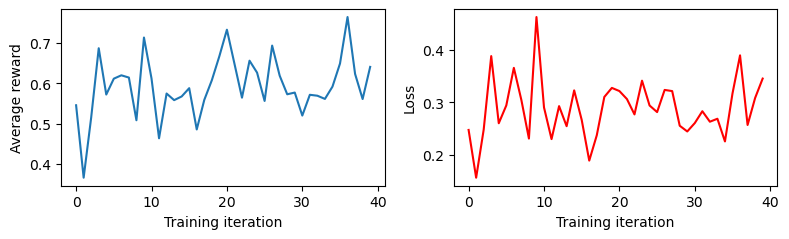

100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Sample trajectories: 100
[5.357, 4.732, 5.203, 0.014, 0.004, 0.027]    CS(=O)(=O)NCCN(C=CC(S(=O)(=O)O1)=CC=CC(S(=O)(=O)O)=CC=C1C(O)CC2CC2COCC3=CC=CC=C3)COC(C)=O
[6.504, 6.085, 6.603, 0.128, 0.057, 0.373]    C1OC=CC(C=C2SC(=O)N1CC(=O)NC3=C(C)C=CC=C3CC=C)=C2OC=C(Cl)C=CC(Cl)=CCl
[5.033, 4.578, 5.060, 0.007, 0.003, 0.020]    C1OC=CC1(NC(=O)C=CC2=CC(Cl)=CC(Cl)=C2O)C=CCl
[6.240, 6.113, 6.130, 0.077, 0.061, 0.162]    COC=CC(C(C(=O)NC(=S)NC1=CC=C(F)C=C1F)SCS2C(C)=C(C)SC2=NC(=O)C3=CC=CF)C=C3
[6.497, 4.877, 5.187, 0.126, 0.005, 0.026]    CCC(CC)C(=O)CS=1C(C2=CC=C(Br)C=C2)=N[NH1]C=1OS(=O)(=O)N3C=CC(S(=O)(=O)N4CCOCC4)=CC=C3NC
[7.583, 6.761, 5.834, 0.780, 0.205, 0.093]    CC=CC(NC(=O)NC(=O)C(=CC1=CC(Br)=CC=C1OCC2=CC=C(Cl)C=C2Cl)NC3=CC=CF)C=C3F
[6.242, 6.618, 6.440, 0.078, 0.158, 0.283]    COC=CC=CC(C(=O)CCCC(C)(C)NC(=O)C(=C1SC(=S)N(C2=CC=C(C)C=C2)C1CN)C(=S)NC(=O)C3=C)C(Cl)=CC(Cl)=C3F
[5.707, 5.388, 6.219, 0.027, 0.015, 0.190]    O=C1CC2(CCC(=O)N2C=CC3=C(Br)C=C)N(CCC4=CC=CC(Br)=C4)CCC3C(=O)NC=C1
[5.

[5.995, 5.173, 5.448, 0.048, 0.009, 0.044]    O=CSC(=CC=1C=C(C)N(C2=CC=C(Cl)C=C2)C=1)C=CC(Cl)=COCCC(C)C
[4.831, 4.669, 4.360, 0.005, 0.003, 0.005]    CCOC(=O)C1=C(C)N=C2SC(=CC(=O)NC3=CC=C(Br)C=C3)C(=O)N2C1C4=CC=C(SC)C=C4
[5.431, 5.254, 5.384, 0.016, 0.011, 0.039]    C1CN(CC)C=C2C=C(C=CC(=N3)NN=C(CC)C34NCCC(O)=NC=S)N4CC5=CC=CC=C5S2=C1
[6.839, 7.380, 7.401, 0.236, 0.580, 1.173]    CCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=CC=C3
[5.808, 5.810, 5.142, 0.033, 0.033, 0.024]    C1C=CC=C1S(=O)(=O)OC2=C(Br)C(Br)=C(Br)C(C)=C2C
[5.949, 6.494, 6.055, 0.044, 0.126, 0.141]    CCC(C(=O)NC1CC(C)C)N1C=CC2(NC(=S)NC(=O)C(=O)N2C3=CC=C(S3)C=C)Br
[7.129, 6.875, 5.923, 0.389, 0.252, 0.110]    C1OC=CC=C(CNCCCC(C)(C2)NCS(=O)(=O)C2C=C1)S(=O)(=O)NC3CCCCC3
[5.027, 4.388, 4.811, 0.007, 0.002, 0.012]    C1NC(=O)C(CC2=CSC(NC3=CC=C(Cl)C4=C3)=CO2)CN1C(C5=CC=C(Br)C=C5)CC4
[5.766, 4.875, 4.680, 0.031, 0.005, 0.010]    CC=CC=CC(CC[NH1]C1=CC=C(C(C)NC(=O)C=CC=C(N2CCN(C(=O)C3=CC=CC=C3)CC2)C(C)

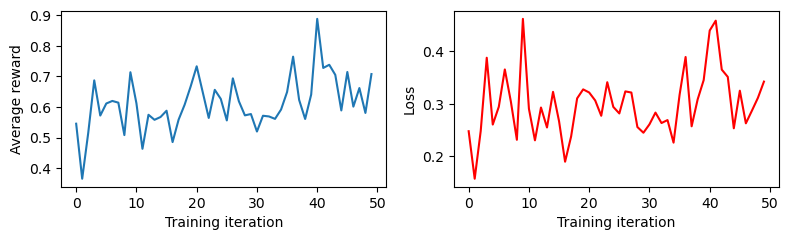

100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


Sample trajectories: 100
[6.680, 5.815, 6.432, 0.177, 0.034, 0.278]    C1CCCOC=CC=C1N(CCCC(=O)NCCC2OC3=CC=C4C=C3O2)C=C4C=O
[6.114, 5.832, 5.918, 0.061, 0.035, 0.109]    CCC(C)NC(=O)CC1OC2=CC=CC=C2C(=O)NC1(C(=O)NCC=CC=C(S(=O)(=O)N(C)C)C=C)C3=CC=C4C(=C3)OCCO4
[5.746, 5.692, 6.026, 0.030, 0.027, 0.133]    CC=CC=C(N(CC(=O)N(CC1=CC=C(Cl)C=C1)C(CC2=CC=CC=C2)C=O)NCC3=CC)C(OC)C(OC)=C3C=COC
[5.803, 5.467, 5.335, 0.033, 0.017, 0.035]    CCCCNC(=O)C(CC)N(CC1=CC=C(OC)C=C1)C(=O)CN(C2=CC=CC(C)=C2C)S(C)(=O)=O
[4.962, 4.167, 4.725, 0.006, 0.001, 0.011]    COC=CC1=C(OC)C(S(=O)(=O)N(C)CC(=O)NC2=CC([N+1](=O)[O-1])=CC=C2N3CCOCC3C=O)C=CC(NC(C)=O)CC1
[6.392, 6.146, 6.261, 0.104, 0.065, 0.206]    CC1=C(Cl)C=CC=C1N(CC(=O)N(CC2=CC=C(F)C=C2)C(C)C(=O)NC3CCCC3S)C=O
[5.919, 5.605, 5.591, 0.041, 0.022, 0.058]    C1OC=CC1(C(=O)OCC=C(C2=CC=CC(OC)=C2OC)NCSC=CC=C(C(=O)OCCOCCCCCCNC)C=O)OC
[6.833, 7.428, 6.010, 0.234, 0.624, 0.129]    COC1=CC=C(CC=C(NS(=O)(=O)C2=CC=C(Cl)C(S(=O)(=O)N3CCOCC3)=C2CC1)C(=O)C4=CC=CCl)C=C4
[5.2

[5.256, 4.984, 5.113, 0.011, 0.007, 0.023]    CC1=CC=C(Cl)C=C1N(CC(=O)N(CC2=CC=C(Br)C=C2)C(CC3=CC=CC=C3)C(=O)NC4CCCC4)S(C)(=O)=O
[6.197, 5.582, 5.423, 0.071, 0.021, 0.042]    COC=CC(OC)=CC(C(=O)NNCNC(=O)C(=C(O)C1=CC=C(Cl)C=C1O)NCC2=CCBr)=CC=C2O
[6.195, 5.489, 5.956, 0.071, 0.018, 0.117]    CC(=O)NCCOC1=CC=C2C=CC=CC2=C1CC(C)(CC(C)(C)CC)COCCCCCCCCCCCC
[6.390, 7.081, 7.180, 0.103, 0.359, 0.889]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=C(OCCN3CCOCC3)C=C2)S(C)(=O)=O
[5.732, 5.444, 5.049, 0.029, 0.016, 0.020]    C1C2=CC=C(S(=O)(=O)N(CC(=O)N3C4CN(C5=CC=CC=C5)CC3)C(=O)C6=CC=CC=C6NCCOCC)COC4C(=O)C2C1OC
[4.820, 4.738, 5.271, 0.005, 0.004, 0.031]    C1NC(CNC(=O)C2=CC=C(Br)C=C2)C3=CC=NN31
[5.246, 4.592, 4.696, 0.011, 0.003, 0.010]    COC=CC=C(OC1)C(CCC(C=CC=C(NS(=O)(=O)C2=CC=CC=C2)C=CN)=C1S)CC(=O)NC(C)C
[4.413, 4.281, 4.636, 0.002, 0.002, 0.009]    CC=CC=C(N(CCCC(=O)N(CC1=CC=C(Br)C=C1)C(CC2=CC=CC=C2)C(=O)NCC(C)C)S(=O)(=O)C3)CC=C(SC)C=C3C=COCC
[6.292, 5.419, 5.733, 0.086, 0.015, 0.076]    C

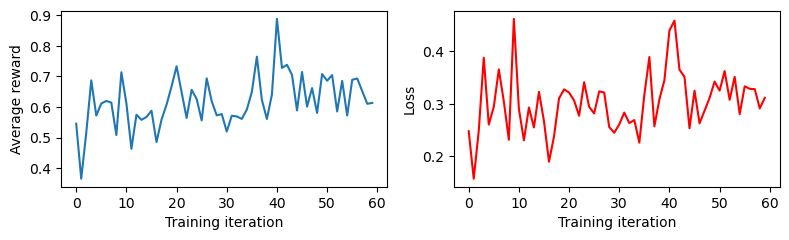

100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Sample trajectories: 100
[7.554, 6.414, 5.405, 0.749, 0.108, 0.040]    COC=CC=CC(N(C(=O)C12SC3=CC(Cl)=CC4=C3S1)C=NC=C(SCC(=O)OCC5=CC=CC=C5)C4)C=C2NS(=O)(=O)C6=CC=C7C(=C6)OCCO7
[5.394, 5.545, 5.276, 0.015, 0.020, 0.031]    COC1=CC(C=C2SC(=O)N(C3=CC=CC(C)=C3)C2=O)=CC=C1OCC(=O)NC4=CC=CC(Cl)=C4
[6.863, 5.915, 5.931, 0.246, 0.041, 0.111]    C1OC=CC2=C(C=NC=CC=C3NC(=S)NC(=O)C4=CC=C(C)C(C)=C4C)CCC3=C2C=C1OCCOCCC
[6.262, 7.128, 5.831, 0.081, 0.389, 0.092]    C1C2=CC=C(CSCC(=O)NC=3SC=C2C=3C=NN=C(SCC4=CC=CC=C4)SC)C1OC
[6.380, 6.172, 6.083, 0.101, 0.068, 0.148]    C1COC=CC1C2=CSC(=S)N(NC(=O)C3=CC=C(Br)C=C3)C2=O
[5.343, 4.931, 4.973, 0.013, 0.006, 0.017]    CCCC1NC(=O)C(C)N(CC2=CC=CC=C2)C(=O)C3OC4=CC=C(Br)C=C4C=C5C(C6=CC=C(O)C=C6)=[N+1]SC5C=C13
[4.251, 3.708, 4.106, 0.002, 0.001, 0.003]    N1CCCC(=O)OC=CC=C1OC(=O)CCC2C(=O)N(C3=CC=CC(C)=C3)C(=O)N2CC4CCCO4
[5.234, 4.489, 4.468, 0.011, 0.002, 0.006]    C1C(C)(C)C(=O)NCCN1C=CC=C(NC(=S)NC(=O)C=CC=C(S(=O)(=S)N2CCCC2)C)C
[5.444, 5.245, 5.021, 0.016, 0.01

[7.340, 6.285, 5.765, 0.546, 0.084, 0.081]    CC1=CC=CC(C)=C1N(CC(=O)NCCOC2=CC=CC(Cl)=C2S)C=O
[7.604, 7.000, 6.294, 0.803, 0.313, 0.218]    CCC=CC=C(N(CCNC(=O)CN(C1=CC(Cl)=C(Cl)C=C1Cl)S(C)(=O)=O)NC(=O)C2=CC=CCl)C(Cl)=C2C
[5.722, 6.027, 6.331, 0.028, 0.051, 0.233]    CCN(CC)C=NC(C=C1C=C(NCCCCC(=O)N2C=CC=CC(=O)NC3=CC=CN=C3)C=C2C)=C1S(=O)(=O)N4CCCCCC4
[7.730, 7.457, 6.300, 0.949, 0.651, 0.221]    C1COC=C(Br)C=C1C=CSC(=S)N(C2=CC=C(S(=O)(=O)N3CCCCC3)C=C2)C=C
[6.288, 5.666, 6.464, 0.085, 0.025, 0.294]    C1OC=CC=C1S(=O)(=O)NCC=CC=CS(=O)(=O)NCC(=O)NC2=CC=CC(Cl)=C2C
[7.973, 6.668, 6.338, 1.274, 0.173, 0.236]    O=CC(=CC1=CC(Br)=CC=C1OC(C)C=CN)C(F)(F)C(=O)NC(C)C(=O)NC(CC(C)C)C(=O)NC(C)C(=O)NC(C(C)C)C(=O)NC(CC2=CC=CC=C2)C(=O)NCCN3C=CN=C3
[5.503, 5.170, 5.629, 0.018, 0.009, 0.062]    C12COC=CC(C3=CSC(=S)N(NC(=O)C4=CC=C(Br)C=C4F)C3)S1C=C2
[8.304, 8.148, 6.657, 1.790, 1.538, 0.408]    C123CN(CC)S(=O)(=O)C=CC1(NC(=O)C4=CC(S(=O)(=O)N5CCOCC5)=CC=C4N)C6CCCCC6=C2CC(C7)=CC3(C)CC(O)C7
[6.260, 5.746, 5.932

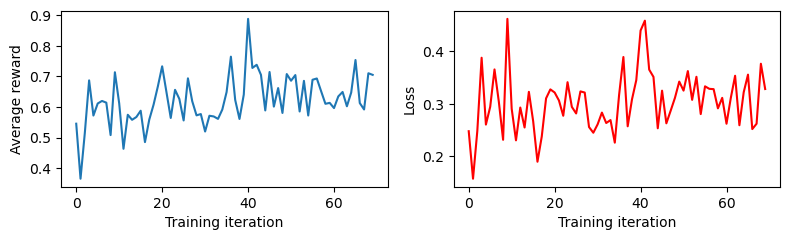

100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Sample trajectories: 100
[6.613, 6.095, 6.339, 0.157, 0.058, 0.236]    O=C(N1C=CC(S(=O)(=O)N2CCCCC2)=CC3=CC=CC=C3NN=CN=CSCC4=CC=C(Cl)C(F)=C4)SC=N1
[6.257, 6.247, 5.510, 0.080, 0.078, 0.050]    COC1=C(C=CC(=O)NC(=O)N(C2=CC=C(OCC3=CC=C(Br)C=C3)C=C2)C)OC4=CC=C(C)C=C4C=C1Cl
[5.541, 4.760, 5.175, 0.020, 0.004, 0.026]    C1C=CC=C(C2=NN(C3=CC=C(C)C=C3)N=C2C(C)=C(C)N1C=O)CNC(=O)C4CCCCC4C=O
[6.700, 7.016, 7.075, 0.184, 0.322, 0.771]    COC1=C2C(Cl)=CC=C1NC(=O)COC(=O)CCCN(S(=O)(=O)CC3=CC=C(C(C)C)C=C3)CC2CC=N
[5.569, 4.886, 5.351, 0.021, 0.005, 0.036]    CCCCNC(=O)C(CC)N(CC1=CC=C(C)C=C1)C(=O)CN(C2=CC=C(Cl)C(Cl)=C2)S(=O)(=O)C3=CC=CC=C3
[7.351, 6.151, 5.998, 0.555, 0.065, 0.127]    CC=C(NC(=O)CSC1=NN=C(C2=CC=C(Br)C=C2)N1C3=CC=CCC(F)(F)F)C3C4=CC=C(F)C=C4
[6.583, 7.390, 6.849, 0.148, 0.589, 0.554]    C1OC=CC=C(S(=O)(=O)N(CC(=O)NCCOC2=CC=C(Cl)C(Cl)=C2)C3=CC=C(F)C(Cl)=C3)C=C1OC
[7.165, 6.400, 6.877, 0.413, 0.105, 0.578]    CC1=CC=C(Cl)C=C1N2C(=S)NC(C3=CC=CC=N3)C2CC=C(N)N(CC4=CC=CC=C4)CO
[6.749, 5.285, 

[5.725, 5.589, 5.998, 0.028, 0.022, 0.126]    C1C=CC=C(C)C(NS(=O)(=O)C=CCOCC(O)C2CC(C)CCC3C=C(OCCC(C)CCC3C(O)C2)CC)N1C(N)=O
[5.910, 4.917, 5.330, 0.041, 0.006, 0.035]    CC1=C(C(=S)NCC2CCCO2)C(C)C=NN=C1SCC(=O)NC=CC(S(=O)(=O)N(C)C)=NNC3=CC=CC=C3
[6.520, 5.899, 6.910, 0.132, 0.040, 0.607]    CC1=C(Cl)C=CC=C1NC(=O)CNC(=O)CCCNC=NC(C2=CC=C(Cl)C=C2)=CSN
[7.709, 6.136, 5.596, 0.924, 0.063, 0.059]    CCC(C(=O)NC(C)C1)N(C(C)C(C)CC=O)NCCN(C(=O)C2=CC(Cl)=CC=C2OCN3C)COCC3CC1
[6.330, 6.443, 5.616, 0.092, 0.114, 0.061]    CC(C)CC=C(C(C1=CC=CC=C1OC)=CC(Cl)=CC(=O)C=C(OC)CCN(C2=NC3=CC=CC=C3S2)CCNC(=O)NC)C4=CC=C(OC)C(OC)=C4
[5.677, 4.857, 4.774, 0.026, 0.005, 0.012]    CCC(S(=O)(=O)NCCCC(=O)NC=CC=CC(N1C=NN=C1)Br)C2CCCO2
[5.423, 4.457, 5.025, 0.016, 0.002, 0.019]    CC=CC(C(=O)N1C(=S)NC=NC=C(Cl)C(Cl)=CNC(=O)CSC2=NN=NN2CCC)S(=O)(=O)C3=CC=CC=C3C=C1
[6.208, 5.799, 5.396, 0.073, 0.033, 0.040]    CCNCCCCCCOC1=C2C=C(C(=O)O)C=C1C(=O)N2CC(=O)NC=CC(S(=O)(=O)N(C)C)=CC3=CC=CC=C3
[6.287, 5.392, 5.682, 0.085, 0.015, 

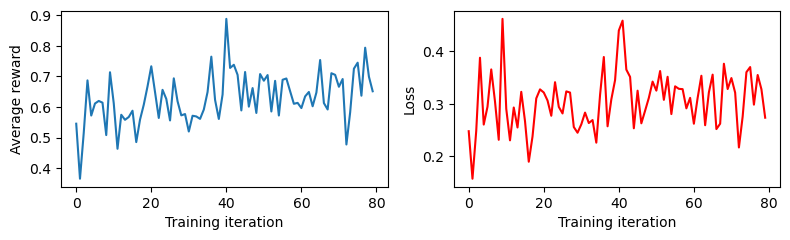

100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Sample trajectories: 100
[5.131, 4.406, 4.800, 0.009, 0.002, 0.012]    CCC(C)C1=CC=COC(C(F)(F)F)=N1
[4.858, 4.195, 5.020, 0.005, 0.001, 0.019]    CCOC=CC=CN(CC(=O)NC=CC=C1OC(S(=O)(=O)N2CCCCCC2)=CC)C1OC(C(=O)C3=CC=CC=C3)C
[6.221, 5.460, 5.240, 0.075, 0.017, 0.029]    COC=CC1=C(S(=O)(=O)NCCN(C(=S)NCC=NN=CSCC(=O)N(C)CC2=CC=C(Cl)C=C2)C(C)C)C=C1
[5.273, 4.795, 4.761, 0.012, 0.004, 0.011]    C1CC=NN=CC=CC=C1NC(=S)NC(=O)C2=CC=C(NC3=CC=C(Br)C=C3)O2
[6.088, 6.254, 6.912, 0.058, 0.080, 0.609]    CC=CC=C(C(C)NC(=O)CN(CC1=CC=C(Cl)C=C1)S(=O)(=O)C2=CC=CC=C2NC3=C)C=C(SC4=CC=C(Cl)C=C4)C=C3
[6.642, 6.138, 5.773, 0.165, 0.064, 0.082]    CCC(C)NC(=O)C(CC)N(CC1=CC=C(C)C=C1)C(=O)CN(C2=CC(C)=CC=C2C)S(C)(=O)=O
[5.509, 5.100, 5.228, 0.018, 0.008, 0.028]    COC1=C(F)C=CC=C1OCC=CC(C2=CC=C(Cl)C=C2Cl)=NC3=CC=CC=C3
[7.552, 5.574, 5.273, 0.746, 0.021, 0.031]    CC=CCOCC(C)N(C(=O)CSC1=CC=C(S(=O)(=O)N2CCCC2)C)C1C3=CC=C(Cl)C(S(=O)(=O)N4CCCCC4C)=C3
[6.018, 5.658, 5.503, 0.050, 0.025, 0.049]    CCOC1=CC(C2=CC=C(CC)C=C2)

[6.880, 6.455, 6.249, 0.254, 0.117, 0.201]    CN(C)S(=O)(=O)C=CC=C(S(=O)(=O)NC=CC1=CC(NC2CC3CC(CC(C3)C2)C)C)C1SC=SC=C[N+1](=O)[O-1]
[5.840, 5.208, 5.441, 0.036, 0.010, 0.043]    O=CCCCCCCNS(=O)(=O)C=CC=C(Br)C=C
[7.540, 6.167, 5.969, 0.734, 0.067, 0.120]    CC(C)(C)OC(=O)NC(CC1=CC=CC=C1)C(=O)NC(CCOC2=CC(F)=CC(F)=C2)CCCNC(=O)COC3=CC=CC(=C34)CCN(CC5=CC=C(Cl)C=C5Cl)CC4
[7.536, 6.258, 5.930, 0.729, 0.080, 0.111]    C1C=CC=C(C=CSC1(C(=O)NC2CC(NC=NC(N3CCCCC3)=CCC(F)(F)F)=N2)SNC)C4=CC=C(Br)C=C4
[5.169, 5.159, 5.440, 0.009, 0.009, 0.043]    CC(C)(C)NC(=O)C(C)N(CC1=CC=C(Br)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[6.848, 6.378, 5.430, 0.240, 0.101, 0.042]    C1C=CC(OC)=CCNS(=O)(=O)C=NN=C1SC2C(=O)CN3C(=O)SC(=CC4=CC=C(O)C(Cl)=C4)OC23
[4.298, 4.012, 4.715, 0.002, 0.001, 0.010]    COC=CC=CC(C1C(C(=O)C(C)(C)C)=NN=C1SCC(=O)NC2=CC(S(=O)(=O)N3CCCCC3)=CC=C2)N4CCOCC4
[6.193, 5.430, 5.615, 0.071, 0.016, 0.061]    C1CCC2C(SC)C1PNC(=S)NC=C2C(C3=CC=C(Br)C=C3)C(C)C(=O)NCC(=O)NCC=CC=CC(CN4CCCC4)=C
[6.677, 6.200

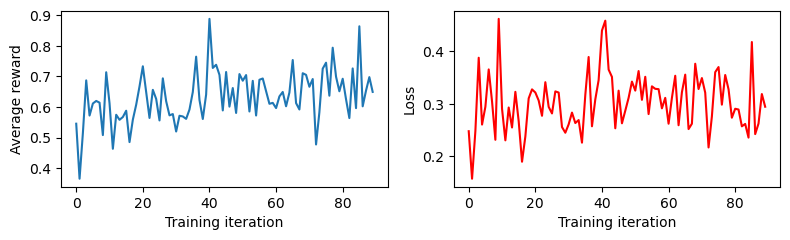

100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Sample trajectories: 100
[5.680, 5.163, 5.154, 0.026, 0.009, 0.025]    CN(C)C=CC=C(S(=O)(=O)NCC=NN=C1SCC(=O)C1SCC(=O)NC2=CC=C(S(=O)(=O)N3CCOCC3)C=C2)C=CCl
[5.918, 5.147, 5.533, 0.041, 0.009, 0.052]    C1NC(C2=CSC(N3)=N2)CCCN(S(=O)(=O)C4=CC(Cl)=CC=C4OCC5=CC=CC)C5CCCC3C(C)=C1
[8.221, 6.808, 5.700, 1.653, 0.224, 0.072]    COC1=CC=C2C=C1NCCN(C(=O)C(C)OC(=O)C(CC(O)C)NNC(=O)CCNCC3C4CCCC4)C3CCCCNC(=O)NC(C(C)C)C(=O)N2
[4.622, 4.077, 4.332, 0.003, 0.001, 0.005]    CC1NC(CNC(=O)C2=CC=CC=C2F)=NN=C1SCC(=O)NC3=CC(Cl)=C(Cl)C=C3Cl
[8.132, 6.367, 6.321, 1.512, 0.099, 0.229]    COC1=CC=CC=C1OCCN2N=NN=C2SC=CC=C(Cl)C(CC(C3)=NN=NN3C4=CC=CC=C4)C=C
[7.327, 6.435, 5.855, 0.535, 0.112, 0.096]    CSC1=NOC(C)=C1COC2=C(Cl)C=C(NC(=S)NC(=O)C3=CC([N+1](=O)[O-1])=CC=C3N4CCOCC4C5=CC=CCl)C=C5CC=C2
[7.287, 6.289, 6.823, 0.503, 0.085, 0.532]    CC(C)CN(C(=O)C1=NC=CS1C2)C3(C)N(C4=C5C(Cl)=CC=C4Cl)C5(C(=O)NCC=CC=C(Cl)C(Cl)=C)CC3=CC(=O)C2(C)C
[5.620, 5.397, 5.360, 0.023, 0.015, 0.037]    CCOC=CC(N1CCOCC1)=CC(NC(=O)C2=CC=C(S

[5.209, 5.847, 5.135, 0.010, 0.036, 0.024]    O=CNC(=S)N(C1=CC=CC=C1F)C(=S)NC(=S)NC2=CC(Cl)=C(Cl)C=C2Cl
[6.679, 7.081, 5.447, 0.177, 0.360, 0.044]    CCCC=C(C(=O)OCC)C(C1=CC=CS1)NC(SCC(=O)N2CCN(S(=O)(=O)C3=CC=C(F)C=C3)C)C2N(CC4=CC=CC=C4)CC5=CC=CC=C5
[4.933, 4.467, 4.707, 0.006, 0.002, 0.010]    O=CCNC=C(C=C1C(=N)N2C(=NC1=O)SN=C2S(=O)(=O)C)CC=C(C)C=C
[7.059, 7.343, 6.612, 0.346, 0.549, 0.379]    CC(C(=O)NC1CCCC1)N(CC2=CC=CC(OC)=C2)C(=O)CN(C3=CC=CC(Cl)=C3Cl)S(C)(=O)=O
[5.655, 5.342, 5.558, 0.025, 0.013, 0.054]    C1CNC(=O)C1(NC(=O)C=CC2=CC(Cl)=CC(Cl)=C2S)C3=CC(Br)=CC=C3O
[7.155, 5.953, 6.285, 0.407, 0.044, 0.214]    CC=CC(N(C)C(=O)N(CCC1=CC=CC=C1)C(C)C(=O)NC2CCCCC2S(=O)(=O)C3=C)C=C(Br)C=C3
[6.080, 5.939, 5.655, 0.057, 0.043, 0.066]    CCN(CC)S(=O)(=O)C=CC=C(OC1=CC=CC(Cl)=C1C)CNC(=S)NC(=O)C=CC2=CC(Cl)=CC(Br)=C2O
[6.106, 6.728, 5.936, 0.060, 0.193, 0.113]    CC=CC=C(S(=O)(=O)N(CC(=O)NC1=CC=C(S(=O)(=S)N2CCCCC2)C=C1C)C=SNCNC(=S)NC3=CC(Cl)=C(Cl)C=C3)Cl
[7.211, 7.905, 6.227, 0.445, 1.178, 0.19

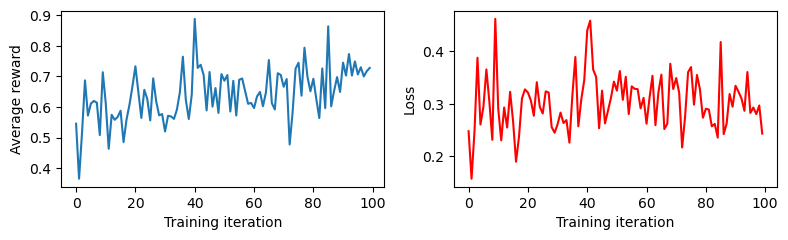

100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Sample trajectories: 100
[7.815, 7.097, 6.548, 1.057, 0.370, 0.340]    C1OC2=C(Br)C=C(Br)C=C2S(=O)(=O)NCCN(S(=O)(=O)C3=CC=C(N4CCCC4)CCl)C3C1(C)O
[6.378, 5.840, 6.062, 0.101, 0.035, 0.142]    CNC(=O)C(C)N(CC1=CC=CC(C)=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(C)(=O)=O
[6.378, 5.823, 6.446, 0.101, 0.034, 0.285]    C1OC=CC(C=CS2C(=S)NC3=CC=CC4=C32)=CC=CC4=N1
[7.427, 6.345, 5.924, 0.623, 0.095, 0.110]    CC1=CC=CC=C1NS(=O)(=O)C=C2C(NC(=O)CSC3=NN=C(C4=CC=C(Cl)C=C4)O3)N2NC(=O)C5=CC=CC([N+1](=O)[O-1])=C5
[6.410, 6.998, 5.864, 0.107, 0.312, 0.098]    CCC(C(=O)N1C(C)(C)C)N(CC2=C3C=C(Cl)C=C2Cl)C(=O)CN(C4=CC=CC=C4OCN)NCC5=CC=C(Br)C=C5C13
[5.484, 5.572, 5.631, 0.018, 0.021, 0.063]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=CC([N+1](=O)[O-1])=C2)S(C)(=O)=O
[5.882, 5.068, 5.404, 0.039, 0.008, 0.040]    COC=C1C=CC(N1CCCC(=O)N(CC2=CC=CC(Br)=C2)C(C)C(=O)NCCCCC)C=O
[6.260, 6.954, 7.404, 0.080, 0.290, 1.176]    CCC1=CC(Br)=CC=C1N(CC(=O)NCCSCC2=CC=CC=C2F)S(=O)(=O)C3=CC=C(Cl)C=C3
[6.481, 7.459, 5.903, 0.122, 

[5.975, 5.394, 5.501, 0.046, 0.015, 0.049]    CCCC(=O)OC1=C(Cl)C=C(Br)C=C1C(=O)NCCOC(CNS(=O)(=O)C2=CC=CC=C2)C(C)CS(=O)(=O)C3=CC=C(Cl)C=C3
[5.585, 5.639, 5.809, 0.021, 0.024, 0.088]    COC1=CC=C(Cl)C=C1NC(=O)C(C)SCC=C2C(=O)NC(=O)N(C3=CC(Cl)=CC=C3C)C2=O
[5.986, 6.241, 5.921, 0.047, 0.077, 0.109]    CC=C1C(NC(=S)N2C(C3=CC=CC=N3)NC(=S)N2CCC(=O)NC4=CC=CS(N)(=O)=O)C=C4C=C1OC
[7.563, 7.900, 7.251, 0.758, 1.172, 0.976]    CCC(C(=O)NCC(C)C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[6.852, 6.223, 6.471, 0.242, 0.075, 0.298]    CCC(N)C(=O)C(C)N(CC1=CC=C(F)C=C1)C(=O)CCCN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[7.155, 7.966, 7.270, 0.406, 1.265, 0.999]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC(Cl)=C2)S(C)(=O)=O
[7.284, 6.670, 6.754, 0.501, 0.174, 0.477]    CS(=O)(=O)NCCN(C(=O)COC=CC=CC=C(NC(=O)COC1=CC(Br)=CC=C1C)C=CC)CCl
[6.161, 5.998, 5.290, 0.066, 0.048, 0.032]    CC=CC(NS(=O)(=O)C1=CC(C(=O)NC2CCN(CC3=CC=CC=C3)CC24)=CC=CCl)C=C14
[7.617, 8.347, 7.739, 0.817, 1.864, 1.684

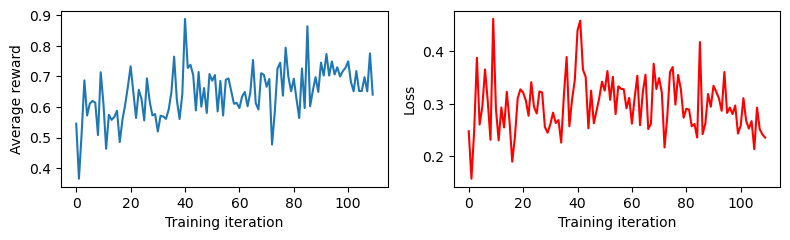

100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Sample trajectories: 100
[7.022, 5.761, 6.274, 0.325, 0.030, 0.210]    CC=CC(Br)=CC(C=NC(SCC(=O)NCC1=CC=C(F)C=C1)N2N=CC(C3=CC(Cl)=CC=C3Cl)=N)C2=CCC=CO
[7.045, 6.319, 6.762, 0.338, 0.090, 0.483]    CCCCNC(SC=NC1(SC=NN=CCC)SC=C1NC2=CC=CBr)C(C(F)(F)F)=C2
[6.184, 6.207, 5.352, 0.069, 0.073, 0.036]    CCOC(=O)C=C(C)NC(SC(C(=O)NC1=CC(Cl)=CC=C1C(C)C)=NNS(=O)(=O)C2=CCC)=CC=C2OC=C
[6.129, 5.891, 5.245, 0.062, 0.039, 0.029]    CCOC(=O)C=C(C)N=CSC(=CC1=CC(Br)=CC=C1OCC2=CC=CC=C2)F
[5.161, 5.317, 6.032, 0.009, 0.013, 0.135]    O=CNC(=S)N(NC1=CC=C(Br)C=C1F)CCN2CCN(C(=O)C3=CC=CC=C3)CC2
[6.493, 6.222, 5.916, 0.125, 0.075, 0.108]    CC1=CC=CC=C1CN(C(=O)CN(C2=CC(Cl)=CC=C2S)C=O)C(C)C(=O)NCC(C)C
[6.787, 7.302, 6.938, 0.215, 0.515, 0.633]    CCCOC=CC=C(CN(CC1=C2C=NC=C1)NC=NC2(SC3=NC=CN3N)C4CCNC4=NC=O)C=C
[7.964, 7.721, 7.555, 1.261, 0.938, 1.396]    CNC(=O)C(C)N(CC1=CC=C(Cl)C(Cl)=C1)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[6.233, 5.888, 6.077, 0.076, 0.039, 0.147]    CCN1C(=O)C(CC)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CO

[5.380, 5.635, 5.332, 0.014, 0.024, 0.035]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC(C)=C2)C(=O)CN(C3=CC=CC(C)=C3)S(=O)(=O)C4=CC=CC=C4
[7.019, 7.531, 6.695, 0.324, 0.725, 0.434]    CC(C)CC(=C1SC(=S)N(C2=CC=CC=C2)C1=O)NCCN(S(=O)(=O)C3=C(Cl)C=CC=C3Cl)CC
[6.128, 4.929, 4.983, 0.062, 0.006, 0.018]    C1OC=CC1(C=CC(=N2)NC(C3CCCCC3)=NN2C=CC=CC=C)Br
[5.655, 5.399, 5.605, 0.025, 0.015, 0.060]    COC1=CC=C(Cl)C=C1N(CCCC(=O)N(CC2=CC=C(Cl)C=C2Cl)C(CC3=CC=CC=C3)C(=O)N)C(C)CS(C)(=O)=O
[7.653, 7.526, 6.416, 0.858, 0.720, 0.271]    O=C(C1=C2C3=C(Cl)C(Cl)=C1)NC=CC(NC(=S)NC(=O)C=C4C(Br)=C(Br)SC4=NC=O)(O)C3C=C2OC
[6.799, 6.066, 6.329, 0.220, 0.055, 0.232]    O=C(CN(C1=CC=CC=C1)S(=O)(=O)C2=CC=C(Cl)C=C2)NC3=CC(Cl)=CC=C3OC4=CC=CC=C4
[6.324, 6.725, 6.208, 0.091, 0.192, 0.187]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC([N+1](=O)[O-1])=CC=C2OC)S(C)(=O)=O
[5.903, 4.959, 5.509, 0.040, 0.006, 0.049]    C1CNCCOC2=CC=C3C=C2CCCCC1CN(C(=O)CNC(=O)SC(=S)NCCC4=CC=CC=C4C)C3C
[6.520, 6.824, 6.448, 0.132, 0.230, 0.286]

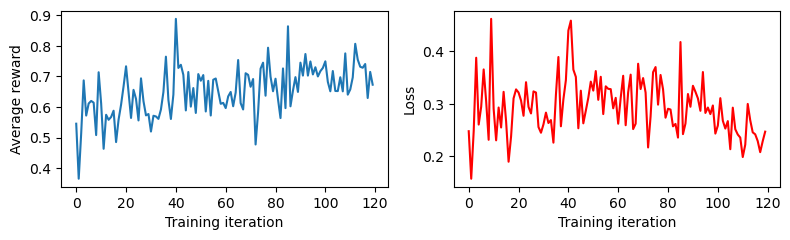

100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Sample trajectories: 100
[7.039, 5.653, 5.795, 0.335, 0.025, 0.086]    C1C(=O)OCCOC(C2O)OC=CC(OC(C3=CC=CC=C3)CCCN(CC)C(C)OC=CC)(OCC4=C(F)C=CC=C4F)CC1C(C)O2
[7.078, 5.811, 6.051, 0.358, 0.034, 0.140]    O=S(=O)C(O)C(CCN(CC1=CC=CC=C1Cl)CCO)CC(COP(=O)NC=C2C=C([N+1](=O)[O-1])COC3=CC(Cl)=CC(Cl)=C3)=C2C=C
[5.902, 6.564, 6.125, 0.040, 0.143, 0.160]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Br)C=C2)C(=O)CN(C3=CC=C(C)C=C3C)S(C)(=O)=O
[5.456, 5.238, 5.490, 0.017, 0.011, 0.048]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CSCC3=CC=C(Cl)C(Cl)=C3
[7.086, 6.411, 6.373, 0.363, 0.107, 0.251]    CCNCCN(C(=O)C1CCC(=O)NC(CSCC2=CC=C(Cl)C=C2)C3CCNC(=O)C4=CC=C(F)S4)CCCC3CC1
[5.005, 4.535, 4.838, 0.007, 0.003, 0.013]    C1C=CN1CCC2NC(=O)C(C3=CC=C(OC)CC3)=CC(C(F)(F)F)=N2
[6.048, 6.365, 5.062, 0.053, 0.098, 0.021]    COC=CC=C(CCN1C(=O)C2=C3C(OC)=CC(=C2)OC4=CC=CC(=C4)C5C=CCC5CC6=CC=C(F)C=C6)N3C=C1C
[6.823, 5.494, 5.593, 0.230, 0.018, 0.058]    CC=CCN=C(S(=O)(=O)C1=CC(C2=CC=C(Cl)C=C2)=NN1CNC)C=O
[5.794, 5.298,

[7.518, 6.389, 6.629, 0.711, 0.103, 0.390]    C1C=CC1(NC=C(CNC2=CC=C(N=NC3=C4C=CC=C3)C=C2C=C5CCl)CC(=O)NCCOC=CC(C)=CC=C)CCC5=C4
[5.763, 6.891, 5.982, 0.031, 0.259, 0.123]    C12NC(=O)N(C)C=CC1(NC(=S)NC(=O)C=3SC4=CC(Cl)=CC=C4C=3Cl)NN2C=C5C=CC=CC5=C[N+1](=O)[O-1]
[6.690, 7.360, 6.667, 0.180, 0.563, 0.414]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(C)=CC=C3OC)S(=O)(=O)C4=CC=C(OC)C=C4
[7.377, 7.698, 6.666, 0.578, 0.911, 0.414]    CCCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.140, 7.671, 7.798, 0.397, 0.879, 1.780]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=CC=C3
[7.101, 6.462, 5.704, 0.372, 0.118, 0.072]    CCC=CC=CCC(N1C(=O)C(=C2C=CC=C(C3=CC=CC=C3OC)O2)COC4=CC=C(Cl)C=C4)=CC(Br)=C1O
[7.097, 5.772, 6.420, 0.369, 0.031, 0.273]    C1NCCN(S(=O)(=O)C2=CC=C(Br)C=C2)C(=S)NC3=CC=C(NCCC=NC=NSN)C3CCCC1
[6.566, 5.565, 5.525, 0.144, 0.021, 0.051]    CCOC1=CC(C2=CC(=O)NN(C3=CC=CC=C3)C2=O)=CC(Cl)=C1OCC4=CC=C(Br)C=C4
[5.720,

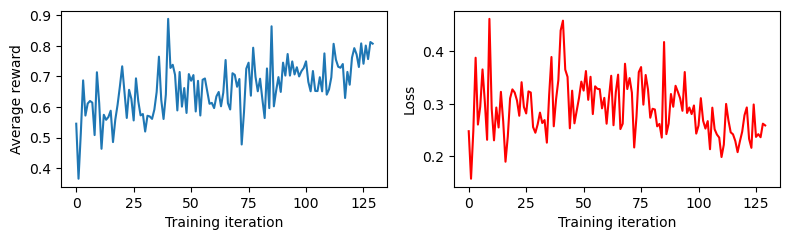

100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Sample trajectories: 100
[5.596, 5.764, 5.726, 0.022, 0.031, 0.075]    CCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C)S(=O)(=O)C2=CC=CC3=CC=CC=C23
[5.925, 4.813, 5.075, 0.042, 0.005, 0.021]    O=C(NC=CC=C1C(S(=O)(=O)N2CCCC2)=C3)C=C1OCC(Cl)C(Cl)=CC(C4=CC(Br)=CC=C4O)=NN3
[6.312, 6.428, 6.102, 0.089, 0.111, 0.154]    COCCNC(=O)SC=CC(NC(=O)COC(=O)CCCC(=O)NC1=CC=C(S(=O)(=O)N2CCCCC2)C=C1)S(C)(=O)=O
[7.282, 7.833, 7.933, 0.499, 1.081, 2.009]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C=C3
[7.153, 7.026, 7.232, 0.405, 0.328, 0.952]    CCN(CC)S(=O)(=O)C=CC=CC(NC(=S)NC1=CC(S(=O)(=O)N2CCCCC2)=CC=C1N3CCOCC3C(=O)NC4=CC=CC=C4)NC
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.244, 6.643, 6.028, 0.470, 0.166, 0.134]    COC(=O)C1=CC2=CC(=C1)NC(C)=CC(C=C3SC(=S)NCCCC(=O)NC4=CC(Cl)=C(Br)C(Cl)=C4F)C=C3O2
[6.307, 5.881, 6.142, 0.088, 0.039, 0.165]    CCNC(=O)C(C)N(CC1=CC=C(Br)C=C1)C(=O)CN(C2)C(F)C(F)=C(C

[7.839, 7.644, 7.158, 1.089, 0.848, 0.864]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(C)(=O)=O
[4.701, 4.073, 4.327, 0.004, 0.001, 0.005]    CCC=NC=COC(NC(=O)C1=CC=CC=C1)CC2=CC(S(=O)(=O)N3CCOCC3)=CC=C2N4CCCCC4
[6.108, 6.412, 5.282, 0.060, 0.108, 0.032]    CCC1CCNN=C(S(=O)(=O)NCCC1(C(=O)NCCCN(CC2=CC=CC=C2)CC)CCCNC=O)C(C)NC(=O)C(CC3=CC=CC=C3)NC=O
[6.441, 5.334, 5.746, 0.114, 0.013, 0.078]    CCC1=CC=CC(C)=C1OCCNC(=O)CN(CC2=CC=C(C)C=C2)S(=O)(=O)C3=CC(Br)=CC=C3O
[5.352, 5.370, 5.265, 0.014, 0.014, 0.031]    CCC(C(=O)NC)N(CC1=CC=C(Cl)C=C1)C(=O)COC=C2C=C(OCC3=CC=C(Cl)C=C3)C=CC4=CC=CC=C24
[6.544, 7.004, 7.396, 0.138, 0.315, 1.165]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC(C)=C2)C(=O)CN(C3=CC=C(Cl)C(C(F)(F)F)=C3)S(=O)(=O)C4=CC=CC=C4
[6.545, 7.239, 6.319, 0.138, 0.466, 0.228]    CC(C)CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=C(OC)C(Cl)=C2)S(C)(=O)=O
[6.954, 6.679, 7.101, 0.289, 0.177, 0.800]    CCNC(=O)C(C)N(CC1=CC=CC=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[6.799, 7.419, 

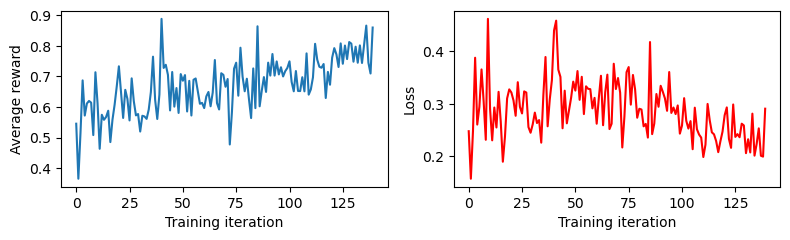

100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


Sample trajectories: 100
[5.716, 4.839, 5.140, 0.028, 0.005, 0.024]    CCCCNCCNC=CC(=CCC1=C[NH1]C2=CC=CC=C2C1=CC3(C4=CC=CC=C4)CN)SC5CCCCC5CC(=O)OCCO3
[5.689, 5.071, 4.974, 0.026, 0.008, 0.017]    CC(N1C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(Cl)S3SCC(=O)OC)=C(C)N1
[7.827, 7.631, 7.242, 1.073, 0.833, 0.965]    C12CCCNC(=O)C(CC)N(CC3=CC=C(Cl)C=C3Cl)C(=O)COC4=CC(C)=CC(C)=C4CC=C1C=C2OCCOCOC(=O)C5=CC=C6C(=C5)OCCO6
[5.129, 5.417, 5.118, 0.009, 0.015, 0.023]    ClC=CC=C(N1CCOCC1)C(NC(=S)NC(=O)C2=CC(Cl)=CC=C2O)CS(=O)(=O)C3=CC=C(OC)C(Cl)=C3
[6.933, 6.816, 5.893, 0.279, 0.227, 0.104]    CC=CC1=CNC(=O)C2=C(N=CN2S(=O)(=O)C3=CC=C4C(=C3)SC(=O)N4CC5=CC(Cl)=CC=C5Cl)CC=C1
[6.319, 7.199, 7.058, 0.090, 0.437, 0.752]    CNC(=S)C(C=CC1=C(N2CCOCC2)C3=CC4C=NCOC5=CC(Br)=CC(Cl)=C5N4)C6=CC=CC=C6C=CCC3=C1COC
[5.467, 4.781, 5.638, 0.017, 0.004, 0.064]    C1CCNC(=O)SC=CC1(NC(=O)CCCN(S(=O)(=O)C2=CC=CC=C2)CCCNC(=O)C3=COC)N3
[8.327, 7.155, 6.835, 1.829, 0.407, 0.542]    CC(C)CCNC(=O)CCC(NC(=O)CCC1=CC=CC=C1)C(=CCC2=

[6.361, 5.154, 5.421, 0.098, 0.009, 0.042]    CC=CC=C(NC(=O)C(=CC=C1C(Br)=C(OCC2=CC=C([N+1](=O)[O-1])C=C2)C(Br)=C1)C(=O)NC)C3=CC(Cl)=CC=C3OC
[8.021, 7.116, 6.183, 1.344, 0.381, 0.178]    CCN(CC)S(=O)(=O)C=CC=C(Cl)CNC(=S)N1C(C2=CC=CC=N2)NC(=S)N1C3CCCCC3CSC=CC=C(Cl)C=C
[5.434, 5.144, 5.109, 0.016, 0.009, 0.023]    C1SC=NN=C(NC2=CC(NCCNC(=O)C=N[NH1]CC=C2O)S(C)(=O)=O)C1C=C(C3=CC=C(Cl)C=C3Cl)NN=C(NC(=O)C4=CC=C(Cl)C=C4Cl)C
[8.225, 7.800, 6.771, 1.661, 1.037, 0.490]    C1C=2N=CSC=2S(=O)(=O)NC(C(=O)NCC(C)OC(=O)CC(CCSC)NC(=O)NC(C)(C3)C=O)NC4(CCCC4)CCCOCNC(=O)CSC(=O)CCC(C)C5(O)C1CC=CC(NCCN6CCOCC6)=CC(=C3)NC7=CC(Cl)=CC=C7CC5C=CCN
[5.932, 5.116, 5.100, 0.043, 0.008, 0.022]    C1OC=CC=C(S(=O)(=O)N(CC(=O)NCCOC2=CC(Cl)=CC(Cl)=C2)C3=CC(Cl)=CCCl)C3C=C1Cl
[6.939, 6.615, 5.255, 0.282, 0.157, 0.030]    C1CNCCN(C(=O)CN(CC2=CC=CC=C2F)S(=O)(=O)N(C)CCC(C)C=O)NC(C)(C)CC=C1OC
[7.280, 7.815, 7.768, 0.498, 1.057, 1.731]    CCNC(=O)CCCN(C)C(=O)C=CC=C(N)N(CCCCC1=CC=CC=C1)NC=NCSCC2=CC=CC=C2S
[8.588, 8.419, 7.586, 2.

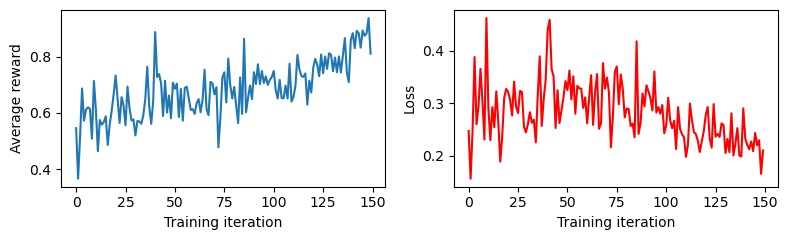

100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Sample trajectories: 100
[6.629, 7.475, 6.508, 0.161, 0.668, 0.317]    CCNS(=O)(=O)C=CC(N1C=CC(=O)NC(=S)NC2=CC=C(S(=O)(=O)N3CCCCC3)C=C2)=C1Cl
[5.526, 5.795, 5.910, 0.019, 0.033, 0.107]    CC(C)NC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[7.312, 6.439, 6.066, 0.523, 0.113, 0.144]    C1CCCNC(N)=CN(C2=CC=C(Cl)C=C2)N=CC3=CC(Br)=CC(Br)=C3OC4=CC=CC(Br)=C4CCC(C)=C1
[7.027, 6.894, 7.017, 0.328, 0.261, 0.711]    CCC(C)NC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[7.023, 8.068, 7.839, 0.326, 1.414, 1.849]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(Cl)C=C3
[5.463, 5.269, 5.612, 0.017, 0.011, 0.060]    CCN(CC)C(=O)CNC(=O)SC(=CC=CC(Cl)=COCC=CC=CC1=CC=CN=C1C=C)C
[6.991, 6.065, 5.828, 0.309, 0.055, 0.092]    CC1=CCN=C1CNCCNC(C)=C(C=CC(=O)N2C(=O)NC3=CC=C4C(=C3)CCC5N4S(=O)(=O)C6=CC(Cl)=CC=C6OCC7=CC8)C(C(C)C)C=C7CC=C2OCCCNC(=O)C(C9=CC=CC=C9)C=CN5OCC%10=CC=CC(=C%10)CC8
[6.508, 7.009, 5.801, 0.129, 0.318, 0.087]    COC=C1C(

[8.005, 8.120, 7.809, 1.321, 1.494, 1.799]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(C)(=O)=O
[6.058, 4.687, 5.363, 0.054, 0.004, 0.037]    O=CSC1=C(Br)C=C(O)C2=C1COCC(C)NC(=O)CN(C(=O)C3CCCCC3)CCNC(=O)CNN=C(N4CCOCC4)N5CC5CCO2
[6.773, 7.370, 5.733, 0.210, 0.571, 0.076]    CC(C)(C)C=CC1=CC(OC)=CC=C1OCC(=O)NN=C(NC2=C3C(Cl)=CC=C2O)NC(C4=CC=CC(Cl)=C4)C(NC5=CC(Cl)=CC=C5Br)C6=CC=CC=C6C3(C)C
[7.567, 7.650, 7.071, 0.762, 0.855, 0.767]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=C(Cl)C=CC=C2Cl)C(=O)CN(C3=CC(Cl)=CC=C3Cl)S(C)(=O)=O
[5.857, 6.671, 5.997, 0.037, 0.174, 0.126]    CCN(CC)S(=O)(=O)C1=CC=CC(Cl)=C1NC(=S)NC(=O)C=CC2=COC(C3=CC=C(C)C=C3)=N[NH1]2
[6.447, 6.242, 5.629, 0.115, 0.078, 0.062]    C1NCCN(C(=O)CNC2CNC(=O)C=C2N(C)C(=S)N(C3)C)C(=O)CNCC=4C(C)=N[NH1]C=4CCC3C5CCCCC5C=C1OC
[6.496, 5.963, 5.943, 0.126, 0.045, 0.114]    CC1N(C)CCCNC(C)=C(C)CC=CC(Br)=CC(S(=O)(=O)O)=CC=CNCCN(CCSCCN2CCCCCC2)C(=O)N1CC(C)C
[6.459, 5.709, 5.811, 0.117, 0.027, 0.089]    COC(=O)CNC(=S)N(C1=CC(Cl)=CC=C1Cl

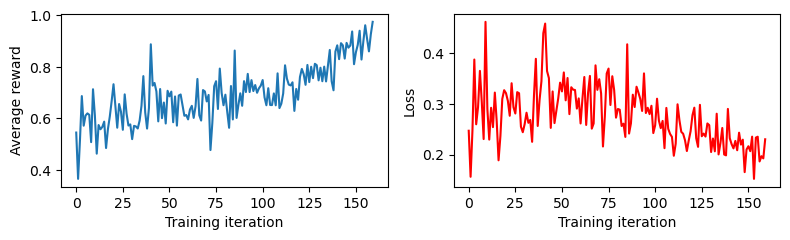

100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


Sample trajectories: 100
[5.824, 4.884, 5.434, 0.034, 0.005, 0.043]    C1C=2N=CSC=2NC(=O)CSC=NN=C1C=CC(F)=C(Br)C(Br)=CC=COC=NN=C
[7.261, 8.140, 7.781, 0.483, 1.525, 1.752]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[6.284, 5.829, 5.843, 0.084, 0.035, 0.094]    CCCCCN(C(=O)C(F)(F)F)CC=C(Br)C=CC=C1C(=O)NC(=O)N(C2=CC=CC=C2)C1=O
[6.634, 6.680, 6.093, 0.163, 0.177, 0.151]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1C)C(=O)CCCN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[6.542, 5.110, 5.507, 0.137, 0.008, 0.049]    CCC=CC=C(C=C(NC(=O)C1=CC=CC=C1)NCSCC(=O)NC2=CC(S(=O)(=O)N3CCOCC3)=CC=C2NCC)N4CC5OCC4N(C6=CC=C(Br)C=C6)C5
[7.726, 6.233, 6.317, 0.944, 0.076, 0.227]    C1NC=NC(CS(=O)(=O)NCCCC(C(=O)N2C(C)C3=CC(Cl)=CC(Cl)=C3C2CC14)CCC)CCC4
[5.945, 5.855, 5.522, 0.044, 0.037, 0.051]    C1SC=CC(NC(=S)N2C(C3=CC=CC=N3)NC(=S)N2C4=CC=CS4C5=CC=CF)C=C5C=CC=C1
[7.055, 7.972, 6.928, 0.344, 1.273, 0.623]    C1N(C)C=CC=C(NC(C)=CC(=O)NC(=S)NC2=CC(Cl)=CC(=C2O)CCN(C(=O)CC3=CC=CC=C3)CC(=O)NCC4=CC=CC=C4)CC=C1N=

[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.087, 7.149, 6.790, 0.363, 0.403, 0.505]    CCNC(SCC(=O)NC1=CC(Cl)=C2C(Cl)=C1N)(C3=CC=CC(C(F)(F)F)=C3)CC2C(=S)NC4=CC=CC(Cl)=C4
[6.789, 6.261, 6.010, 0.216, 0.081, 0.129]    CC=CC(C)=C(S(=O)(=O)N(CC(=O)NCCSCC1=CC=CC(Cl)=C1)NC(=O)NC2=CCCl)CC(Cl)=C2C=COC
[5.841, 5.309, 5.254, 0.036, 0.012, 0.030]    CC1=CC(C=CS2C(=S)N(C3=CC(Cl)=CC(Cl)=C3)C2=CC)=C1OCC4=C(Cl)C=CC=C4Cl
[9.627, 8.702, 7.448, 4.267, 2.491, 1.239]    COCCNC(SCC1NC(=O)C=CC=C(NC(=S)NC(=O)C2=CC(Cl)=CC(Cl)=C2OC3=CC=CS3)C=C)C4=CC=CC=C4O1
[7.672, 7.613, 6.413, 0.879, 0.812, 0.269]    O=CNC(=N)N(C1=CC=CC(Cl)=C1Cl)C(=S)NC(=O)CCCC2CC(CN2CC3=CC=CN=C3)CC4=CC=CC=C4F
[7.050, 7.206, 6.970, 0.341, 0.442, 0.663]    CC(C)NC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[5.687, 5.070, 5.825, 0.026, 0.008, 0.091]    CNC(=O)C(C)N(CC1=CC=CC(OC)=C1)C(=O)CN(C2=CC=CC(C(F)(F)F)=C2)S(C)(=O)=O
[7.262, 7.448, 7.205

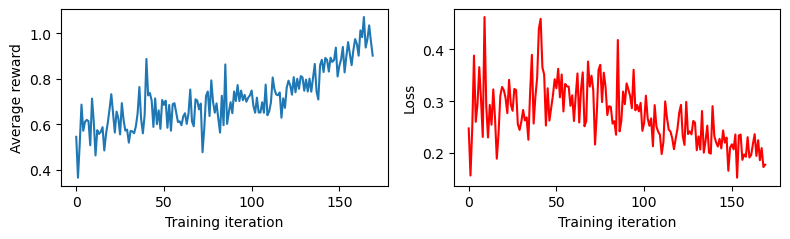

100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Sample trajectories: 100
[7.019, 7.235, 6.860, 0.324, 0.463, 0.563]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(F)C=C2)C(=O)CN(C3=CC(C(F)(F)F)=CC=C3Cl)S(C)(=O)=O
[7.984, 7.974, 7.649, 1.291, 1.276, 1.540]    CCNC(=O)C1=CC(Cl)=CC(Br)=C1N2C(CC(N)=O)=CC(Br)=C2OS(=O)(=O)C3=CC(Cl)=CC(Cl)=C3
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[6.726, 6.993, 6.647, 0.193, 0.310, 0.401]    CCNC(=O)C(C)N(CC1=C(Cl)C=CC=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(C)(=O)=O
[8.115, 8.495, 7.199, 1.487, 2.118, 0.912]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.580, 6.536, 6.700, 0.777, 0.136, 0.437]    CNC(=O)CNC(=O)N1C=CC(=CC=C1O)CCN(C2C(=O)N3CCC(C)CC3)C=CN2C4=CC(Cl)=CC(Cl)=C4O
[7.454, 7.870, 6.665, 0.648, 1.131, 0.413]    CCCNC(=O)C(C)N(CC1=C(Cl)C=CC=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[5.954, 6.289, 6.273, 0.044, 0.085, 0.210]    C1CNC1(SCC(=O)NC=CC=C(S(=O)(=O)N2CCCC2)C=C)C(C(=O)NC3CCCCC3)C4=CC=C(F)C=C4
[6.616, 6.31

[8.019, 7.440, 6.645, 1.342, 0.635, 0.400]    CCNC(SCC(=O)NC1=CC=C2C(=C1)CCCN2C(=O)CN3CCNC4=CC(Cl)=CC=C4C)CC3=NC=CC(S(=O)(=O)NCC)C(NC5=CC=C(F)C=C5)C(N)=O
[6.723, 5.511, 5.868, 0.192, 0.019, 0.099]    C1CNC1(SC=CC=C(S(=O)(=O)NCC(C)(C)NC(=O)C2=CN=CC)N2C(=O)N)C3=CC=CC=C3F
[6.776, 7.104, 7.593, 0.211, 0.374, 1.453]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=C(OC3=CC=CC=C3)C=C2)S(C)(=O)=O
[7.617, 8.347, 7.739, 0.817, 1.864, 1.684]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[7.187, 6.499, 6.228, 0.428, 0.127, 0.194]    CNN=C(CC(O)(C1=CC=CC=C1)NC(=S)NC(=O)C=CC=C(Cl)CS(=O)(=O)N2CCCCC2)CC=CCl
[6.288, 5.528, 5.467, 0.085, 0.019, 0.046]    COC(=O)C=CC=C(COC1CCNC=C(C=CSC(=S)NC2=CC=CC=C2CC3)CC(Br)=CC=C3)C1=O
[6.145, 6.096, 5.736, 0.064, 0.059, 0.077]    CC(C)CC(N1C(=O)CN2C=CN=C2)SC1NC(=S)NC(=O)C3=CC(S(=O)(=O)N(C)C)=CC=C3NCCOCCOCC4=CC=CC(=C4)OC

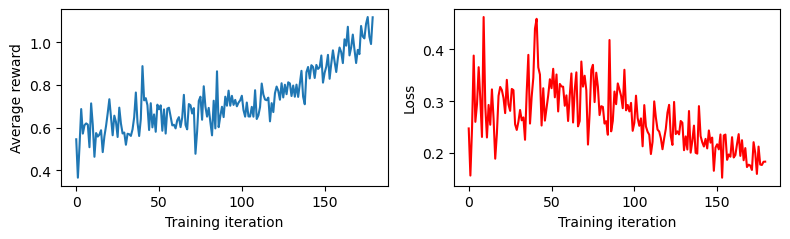

100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


Sample trajectories: 100
[6.760, 7.606, 6.842, 0.205, 0.805, 0.548]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC(Br)=C2)C(=O)CN(C3=CC(Cl)=CC=C3C)S(C)(=O)=O
[6.669, 7.984, 7.055, 0.174, 1.290, 0.750]    COC=CC=C(NS(=O)(=O)C=CC(C(=O)NC=CC1(S(=O)(=O)NC2=CC(Cl)=CC=C2C=C)N=3)C(C)=N)[NH1]C=3C(C)C=C1C4=CC=C(Cl)C=C4C(F)(F)F
[6.133, 5.948, 6.053, 0.063, 0.044, 0.140]    CNC(=O)CC(C(=O)NC1=C(Cl)C(Cl)=CC=C1Br)C2=CC(Br)=CC=C2N3CCOCC3C4=CC(Cl)=CC(Br)=C4
[7.090, 7.320, 7.315, 0.365, 0.529, 1.057]    CCN(CC)C(=O)C1=C(NC2=C3C(Cl)=CC=C2Cl)NCCC3C4=CC=C(Br)C=C4C(=O)NC1=S
[7.265, 7.355, 7.313, 0.486, 0.559, 1.054]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(C)=CC=C3C)S(C)(=O)=O
[6.304, 5.812, 6.336, 0.087, 0.034, 0.235]    COC1=CC=CC(=C1OC)CN(C(=O)C2=CC=C(CC)C=C2)CNN=CC3=CC(Br)=CC=C3N=C
[7.080, 6.450, 6.251, 0.359, 0.116, 0.202]    CNC(=O)C(C)N(CC1=CC=CC=C1)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[6.890, 5.511, 5.750, 0.259, 0.019, 0.079]    CCC(C(=O)NC1CCCCC1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CCCN3C(=O)C4=

[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.336, 7.304, 6.678, 1.844, 0.516, 0.422]    CNC(=O)CCCCNC(=S)NC(C1=CC=C(Cl)C=C1)(N2CCN(S(=O)(=O)C3=C(Cl)C=CC=C3Cl)C)C2CN4CCN(C5=CC=CC=C5Cl)CC4
[5.030, 4.450, 4.799, 0.007, 0.002, 0.012]    C1NCCN(C=CC(N2CC3OCC2)=NC(NC=C4C(S(=O)(=O)O)=CC([N+1](=O)[O-1])=C4C=O)N3)CC=CC(Cl)=C1OC(F)F
[5.141, 4.786, 5.383, 0.009, 0.004, 0.039]    CCNC(SCC(=O)NC1=CC(Br)=CC=C1)Br
[6.250, 5.665, 5.536, 0.079, 0.025, 0.052]    CNN=CC=C(C12N=CC(=S)NC3=CC(Cl)=C(Br)C=C3C(=O)N1C4=CCOC)CC(OC)=C4C=C2OC
[6.360, 5.866, 5.792, 0.097, 0.037, 0.085]    O=C1NC(=S)N(C2=CC=CC=C2Cl)C(=O)C1=CC3C=C(C)N(C4CCS(=O)(=O)C4)C3=O
[6.547, 6.963, 5.720, 0.139, 0.294, 0.075]    O=C(NC(=S)N1C=C(Br)C1C(=O)NCC2NC(=O)C(CC3=CC=CC=C3)NC(=O)C(C45C=CCC2CC4)C6C5OC)C7C(O)=CC(O)=CC7=N6
[7.351, 8.058, 7.618, 0.555, 1.399, 1.492]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[6.059, 5.565, 5.590, 0.055, 0.021, 

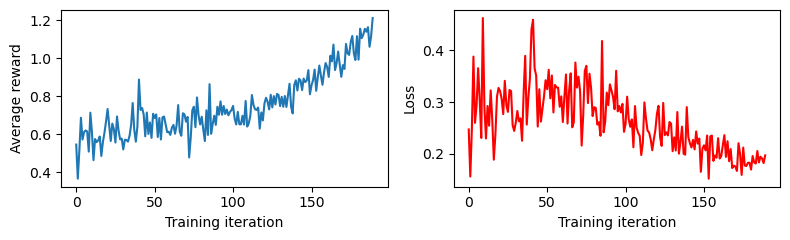

100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


Sample trajectories: 100
[6.446, 5.581, 5.304, 0.115, 0.021, 0.033]    CN(C=CC([N+1](=O)[O-1])=C(Br)C(Br)=CNC(=O)CSC=NC(O)=CC=C(C)SC1=NCCl)NN1SC=N
[6.087, 6.055, 6.231, 0.058, 0.054, 0.195]    COC=CC=C(C1N2CC(C(=O)NC=NC(NC3=CC=CC=C3)SN=C1)C4)CC=C(OC)C=C4OC=N2
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[6.305, 6.675, 5.937, 0.088, 0.176, 0.113]    CCCNC(=O)C(CC)N(CC1=C(Cl)C=CC=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C=C3
[5.612, 5.382, 5.255, 0.023, 0.014, 0.030]    CN(C)C(=O)C=CC=CCCOC=CC=C(C=C1C(=N)N2C(=NC1=O)SN=C2S(C)(=O)=O)C=C
[7.014, 6.818, 7.080, 0.321, 0.228, 0.777]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC([N+1](=O)[O-1])=CC=C2)CS(C)(=O)=O
[6.655, 6.350, 5.905, 0.169, 0.096, 0.106]    C=1CN(C(=O)CSC=1C(=O)NCC2=CC=CO2)CC3=CC(Cl)=CC(Cl)=C3S(C)(=O)=O
[4.976, 4.531, 4.990, 0.006, 0.003, 0.018]    CNN=C1C(Cl)=CC(N)=C1NC(=S)NC(=O)C2=CC(S(=O)(=O)N3CCOCC3)=CC=C2N4CCOCC4
[5.041, 4.620, 4.893, 0.007, 

[7.261, 8.140, 7.781, 0.483, 1.525, 1.752]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[7.080, 6.326, 6.139, 0.359, 0.091, 0.164]    C1C2(C)C=NC(N)=C1N2C(=O)COC=CC(NC(=O)C3=CC=CS3)=CCNCC(C)NCC=C(C)N
[8.020, 7.174, 7.013, 1.343, 0.419, 0.706]    CNC(=O)C(C)N(CC1=CC=C(F)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[6.988, 7.530, 6.080, 0.307, 0.724, 0.148]    O=C(CN(C1=CC(C(F)(F)F)=CC=C1Cl)S(C)(=O)=O)ONC(C)(C)CS(=O)(=O)C2=CC=C(C)C=C2
[8.149, 7.396, 6.677, 1.539, 0.595, 0.421]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(Cl)=CC=C3Cl)S(C)(=O)=O
[7.745, 7.718, 7.453, 0.968, 0.934, 1.246]    CC(C)NC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[7.633, 8.140, 7.635, 0.835, 1.525, 1.518]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(Br)C=C3
[5.101, 4.629, 4.814, 0.008, 0.003, 0.013]    CCC=1NC(=O)C=1CC=CSC
[6.181, 6.547, 6.585, 0.069, 0.139, 0.362]    C1C=CC(C=C2SC(=S)N(C3=CC=C(Cl)C(Cl)=C3)C2=O)

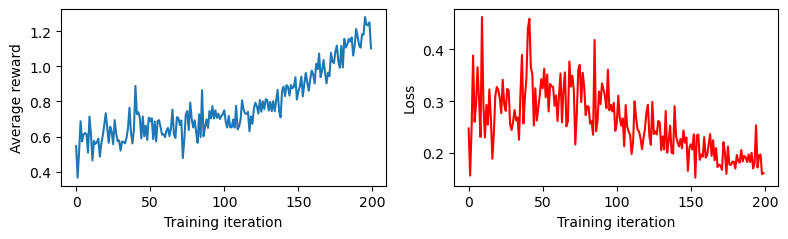

100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


Sample trajectories: 100
[7.265, 7.355, 7.313, 0.486, 0.559, 1.054]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(C)=CC=C3C)S(C)(=O)=O
[6.799, 7.419, 6.716, 0.220, 0.615, 0.449]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C)=CC=C2C)S(C)(=O)=O
[7.986, 8.454, 7.490, 1.292, 2.046, 1.298]    CNC(=O)C(C)N(CC1=CC=C(Cl)C(Cl)=C1)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[7.670, 8.398, 7.726, 0.878, 1.950, 1.662]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[7.554, 7.721, 8.071, 0.748, 0.938, 2.253]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC=C3Cl
[7.351, 8.058, 7.618, 0.555, 1.399, 1.492]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[7.745, 8.155, 7.543, 0.967, 1.549, 1.377]    CNC(=O)C(C)N(CC1=CC=CC(Br)=C1)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[5.336, 5.010, 5.377, 0.013, 0.007, 0.038]    CCN(CC)CCCC(C)NC(=O)C(=CC(=S)NC=NN=CSCC(=O)NC1=C(Cl)C=C(Cl)C=C1Cl)N=N
[7.588, 7.

[7.163, 7.706, 6.966, 0.412, 0.921, 0.660]    C1NC(=O)SC=CC1(NC(=O)CSC=NN=C(C2=CC(Br)=C(Br)C([N+1](=O)[O-1])=C2)NN)C3=CC(Cl)=CC=C3OC=CCS(N)(=O)=O
[6.509, 6.171, 6.735, 0.129, 0.068, 0.463]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)COC2=CC=C(C(C)(C)C)C=C2Br
[7.468, 8.273, 7.895, 0.662, 1.740, 1.944]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C)=CC=C2C)S(C)(=O)=O
[6.606, 7.495, 6.559, 0.155, 0.688, 0.346]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Br)C=C2)C(=O)CN(C3=CC(C)=CC=C3C)S(C)(=O)=O
[6.547, 5.948, 6.152, 0.139, 0.044, 0.168]    CNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(=O)(=O)C3=CC=CC=C3
[7.627, 7.985, 7.233, 0.828, 1.291, 0.954]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C(Cl)=C1)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.113, 8.066, 7.409, 1.483, 1.411, 1.184]    CCNCCCCCC1N(C(=O)C2=CC=NC=C23)CCS(=O)(=O)C3N=C(NCC4=CC5=CC(Cl)=C4)C(C)NC(=O)C(NC(=O)CCCCCN5)C1
[8.017, 8.129, 7.382, 1.339, 1.509, 1.147]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(

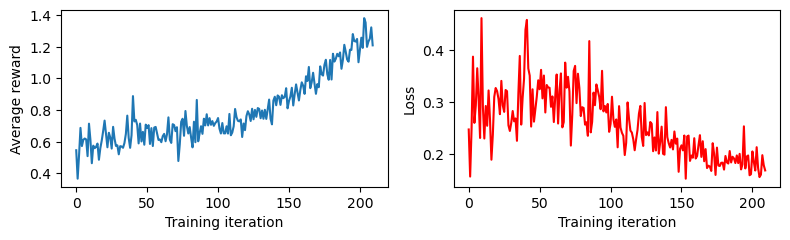

100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


Sample trajectories: 100
[6.711, 6.297, 5.729, 0.188, 0.086, 0.076]    COC1=CC=CC(=C1)C(C2=CC=C(C3=C2Br)OCC=CC)CCCCCCOC(=O)N(CC)C3NC(=S4)NC(=S5)NC=C(C)N=C54
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.636, 9.234, 7.958, 2.371, 3.499, 2.053]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[8.233, 7.192, 7.801, 1.674, 0.432, 1.786]    CNC(=O)C(C)N(CC1=CC=C(Cl)C(Cl)=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C(C)=C3
[8.145, 8.767, 8.059, 1.534, 2.610, 2.232]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[6.644, 6.642, 6.376, 0.166, 0.165, 0.253]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=C(C)C(C)=CC=C2)OCS(=O)(=O)C3=CC(C)=CC=C3C
[7.346, 7.563, 6.750, 0.551, 0.758, 0.474]    CCNC(=O)C(CC)N(CC1=CC(Cl)=CC=C1C)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[6.401, 5.371, 5.118, 0.105, 0.014, 0.023]    CNC(=O)C(C(

[7.029, 7.784, 7.060, 0.329, 1.018, 0.755]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(Cl)=CC=C3OC)S(=O)(=O)C4=CC=C(OC)C(OC)=C4
[7.064, 6.321, 5.998, 0.349, 0.090, 0.126]    CNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[6.895, 7.008, 5.872, 0.261, 0.317, 0.100]    CCC(=O)NC1=CC=CC(=C1)N(CC2=C3C(Br)=CC=C2O)CNC(=S)NC=CC=C4C3(NC(=O)NC5=CC=CC=C5Cl)CC(=O)CNC(=O)NC(C)(C6=CC=CC(F)=C6)SC4
[7.282, 7.833, 7.933, 0.499, 1.081, 2.009]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C=C3
[6.639, 5.592, 5.499, 0.164, 0.022, 0.048]    CC(=O)NCCC(NC(=O)CCCN(C1=CC(Cl)=CC(Cl)=C1)S(C)(=O)=O)C(=O)NC2CCCCC2S(=O)(=O)C3=CC=CC=C3
[6.436, 7.310, 6.732, 0.113, 0.521, 0.460]    CCNC(=O)C(CC)N(CC1=C(Cl)C=CC=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C=C3
[5.969, 5.281, 5.709, 0.046, 0.012, 0.073]    CCNC(CNC(=O)C=CN(C)C(Br)=CC=CBr)NN=CN(C(=S)NC1=CC=CC=C1)C2=CC(Cl)=CC=C2C
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC

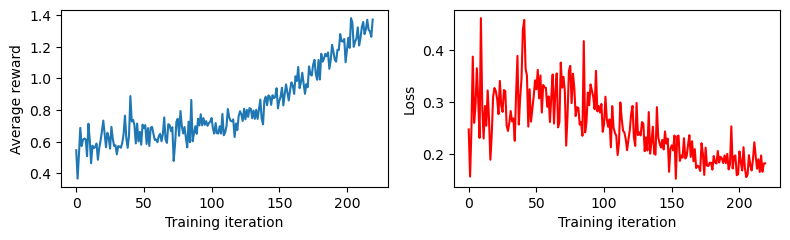

100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Sample trajectories: 100
[6.911, 6.643, 5.610, 0.268, 0.166, 0.060]    CCCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CNN=C(CNC2=CC(Cl)=CC=C2)CNC(=O)C3=CC=CC=N3
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[7.454, 7.993, 7.378, 0.648, 1.303, 1.141]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2C)S(C)(=O)=O
[6.071, 6.166, 6.829, 0.056, 0.067, 0.537]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC([N+1](=O)[O-1])=CC=C2C)CC3=CC=CS3
[7.100, 7.168, 7.200, 0.371, 0.415, 0.913]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=C(Cl)C=CC=C2Cl)C(=O)CN(C3=CC(C(F)(F)F)=CC=C3Cl)S(C)(=O)=O
[6.198, 6.712, 6.105, 0.071, 0.188, 0.154]    CN(C)C=CC(NS(=O)(=O)C=CC(C(=S)NC(=S)NCC1(C2=CC=C(Cl)C=C23)CCCCC1)NC4)=NC(SCC(=O)C5=CC=CC(C)=C5)N4C3
[6.032, 6.500, 5.676, 0.052, 0.127, 0.068]    CNC(=O)C(CC)N(CC1=C2C=C(Cl)C=C1Cl)C(=O)COC3=CC(Cl)=C(CNC=NC3(C4=CC=NC=C4)C)OC=C2OC
[7.267, 6.518, 6.197, 0.487, 0.131, 0.183]    CCNC(SCCNC(=O)NC1=C(C)C=

[7.877, 7.918, 6.695, 1.140, 1.196, 0.434]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.247, 7.044, 7.206, 0.472, 0.338, 0.920]    CCNC(=O)C(C)N(CC1=CC=CC(Br)=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(Cl)=CC=C3Cl
[5.263, 4.979, 4.809, 0.011, 0.006, 0.012]    CC=CC=C(C)C(N(C(=O)CN1N=NC2=CC=CC=C21)C(C(=O)NCC3CCCO3)C4=CCCl)=CC(C)=C4C=C
[7.161, 8.166, 7.687, 0.410, 1.565, 1.600]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(Cl)=CC=C3C)S(C)(=O)=O
[8.276, 7.708, 7.342, 1.745, 0.923, 1.092]    CNC(=O)C(CCCS(=O)(=O)N)C1=CC(Br)=CC(Br)=C1C=CN(CCNC(=O)C2=CC=CC(Cl)=C2N)C(=O)C3CC(CC)CN3C(=O)C=CC4=C[NH1]C(=O)N4C=O
[5.620, 5.638, 5.974, 0.023, 0.024, 0.121]    CCNC(=O)C(CC)N(CCC1=CC=CC=C1)C(=O)CN(C2=CC=C(OC)C(OC)=C2)S(C)(=O)=O
[7.261, 8.140, 7.781, 0.483, 1.525, 1.752]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[7.386, 7.387, 7.224, 0.585, 0.587, 0.942]    CNC(=O)C(C)N(CC1=C(Cl)C=CC=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C

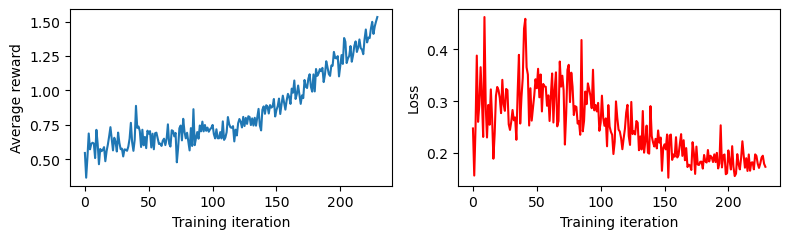

100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Sample trajectories: 100
[6.799, 7.419, 6.716, 0.220, 0.615, 0.449]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C)=CC=C2C)S(C)(=O)=O
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[6.223, 5.550, 5.691, 0.075, 0.020, 0.070]    CC=CC(C)=CC(NC(=O)CSC=NC(NC(C1=CC=CC=C1)C2=CC(Cl)=CC)=C2N3CCOCC3C(=O)NC45CC6CCCC(C6)C4)C5
[7.351, 8.058, 7.618, 0.555, 1.399, 1.492]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[7.597, 7.742, 7.692, 0.795, 0.964, 1.608]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=CC=C3Cl
[6.630, 7.092, 6.772, 0.162, 0.366, 0.491]    CCNC(=O)C(CC)N(CC1=CC=CC=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[5.270, 4.656, 5.200, 0.012, 0.003, 0.027]    CCC(C(=O)N1C2CCCCC2)N1CC=C(Cl)C=CC(Cl)=C
[8.148, 8.443, 7.582, 1.538, 2.028, 1.435]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[7.960, 7.50

[5.232, 4.887, 5.016, 0.011, 0.005, 0.019]    CCNC(=O)C(C1)N(CC2=CC=CC(Cl)=C2C)NC(=O)CNN=CC(C=3)=CC(=O)N(C4=CC=C(Cl)C(Cl)=C4)C=3C=C1[N+1](=O)[O-1]
[7.150, 6.534, 5.672, 0.403, 0.135, 0.068]    CNC(=O)C(CC)N(CC1=C(Cl)C=CC=C1Cl)C(=O)CN(C2=CC([N+1](=O)[O-1])=CC=C2OCS)C=O
[8.089, 6.399, 6.877, 1.446, 0.105, 0.578]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(N=CC(N2CCCCC2)=CCOC)CC=CC(F)(F)Cl
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.148, 8.443, 7.582, 1.538, 2.028, 1.435]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[7.886, 7.300, 6.123, 1.153, 0.513, 0.160]    CC=CC(NS(=O)(=O)C=CC=C(Cl)CC(=O)NC=NC(C1=CC=C(Cl)C=C1)=NC2=CCO)=NC23CSCN3
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[6.154, 4.955, 4.995, 0.066, 0.006, 0.018]    CNS(=O)(=O)C=CC=C(CCNC(=O)C(C)NC(=O)C=C1C2=CC=CN1N)N(CCN(C)C)C2
[

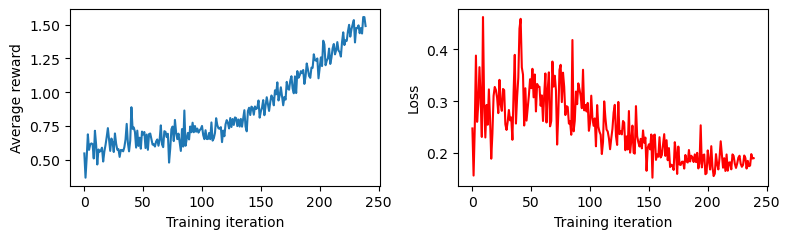

100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


Sample trajectories: 100
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.351, 8.058, 7.618, 0.555, 1.399, 1.492]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[5.874, 5.640, 5.486, 0.038, 0.024, 0.047]    CCNC(SCCNC(=S)NC1=NC(C(C2=CC(Cl)=CC=C21)NC=C)CNS(=O)(=O)C3=CC=CC=C3)C(=O)NCC4=CC=C(C)C([N+1](=O)[O-1])=C4
[8.148, 8.443, 7.582, 1.538, 2.028, 1.435]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[7.930, 8.110, 7.381, 1.213, 1.479, 1.145]    CNC(=O)C(C)N(CC1=CC=CC(Br)=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[8.209, 8.019, 6.828, 1.635, 1.342, 0.536]    CCC(C(=O)NC1CCCC1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(C(F)(F)F)=CC=C3Cl)S(C)(=O)=O
[6.967, 6.389, 6.846, 0.296, 0.103, 0.551]    CNC(=O)N(C)C=CC(NC(=O)CNC(=O)SC(=CC1=CN(CC2=C3C=C(Cl)C=C2Cl)C=CC4=CC(Cl)=C)CBr)=C4C=C1NC(=S)NCCNC(=O)C3=C
[8.148, 6.538, 5.959, 1.538,

[6.233, 7.244, 6.591, 0.076, 0.470, 0.366]    CCNCC=NN=C(S(=O)(=O)NC1=CC(Cl)=CC([N+1](=O)[O-1])=C1)C2=NC(C3=CC=C(Cl)C(Cl)=C3S)C2=NCC4=CC=C(F)C(Cl)=C4
[8.775, 8.325, 7.984, 2.625, 1.825, 2.098]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[6.399, 6.075, 6.298, 0.105, 0.056, 0.220]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CNC=CC(S(=O)(=O)N(C)C)=CC(Cl)=CCl
[7.608, 7.833, 7.535, 0.807, 1.080, 1.365]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(C(F)(F)F)=CC=C3Cl)S(C)(=O)=O
[6.491, 5.954, 6.086, 0.125, 0.044, 0.149]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=N2)C=O
[6.817, 7.491, 6.546, 0.227, 0.684, 0.339]    CCCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[8.152, 8.218, 7.991, 1.543, 1.650, 2.111]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(Cl)=CC(Cl)=C3
[6.367, 6.756, 6.703, 0.099, 0.204, 0.440]    CCNC(=O)C1(CC)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC=C(OC4=CC=CC=C4)C=

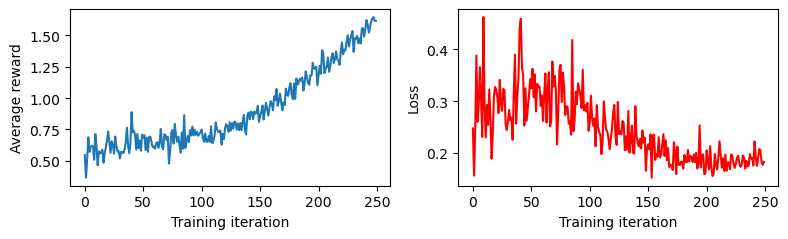

100%|██████████| 100/100 [00:07<00:00, 12.80it/s]


Sample trajectories: 100
[8.148, 8.443, 7.582, 1.538, 2.028, 1.435]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[7.839, 7.644, 7.158, 1.089, 0.848, 0.864]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(C)(=O)=O
[5.538, 5.232, 5.080, 0.020, 0.011, 0.021]    CCCN1N=CC(C(=O)NC(=S)NC2=CC(Br)=CC(Br)=C2OC1C3=CC(Br)=CCBr)=C3O
[8.167, 8.670, 7.763, 1.568, 2.433, 1.723]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[6.268, 5.964, 6.613, 0.082, 0.045, 0.379]    CCNC(=O)C(NC(=O)C1=CC(F)=CC(Br)=C1OC)=NN=CSCC(=O)NC2=CC(Cl)=C(Cl)C=C2Cl
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[8.711, 8.010, 8.153, 2.506, 1.329, 2.401]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C

[7.608, 7.833, 7.535, 0.807, 1.080, 1.365]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(C(F)(F)F)=CC=C3Cl)S(C)(=O)=O
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.892, 8.135, 6.984, 1.160, 1.518, 0.677]    CCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.910, 7.404, 6.414, 1.185, 0.602, 0.270]    COC=CC(S(=O)(=O)N1CCOCC12)=CC(NC(=S)NC(=O)C3=CC(Br)=CC(Br)=C3OCSC2=SN)CCOC(C)(C)CCCCN(C(=O)CS4C(NCC5=CC(Br)=CC6=N5)OC7=CC(Cl)=CC[N+1](=O)[O-1])C7C=CC(=O)OCC(C)CC(C)(C)CC46N
[7.925, 7.103, 6.655, 1.205, 0.373, 0.406]    C1OCC(=O)NC=CC=C1NC(=S)N2C(C3=CC=CC=N3)NC(=S)N2C4=CC(Cl)=CC=C4OC=CC=C
[6.490, 6.184, 5.999, 0.125, 0.070, 0.127]    NCC(N)=C(C(=S)NCCCN(C)C(=O)C(C)N1C(=O)COC2=CC(Cl)=C(Cl)C=C2CCN1)C(=O)OC(C)(C)C
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[7.670, 8.398, 7.726, 0.878, 1.950, 1.662]    CCNC(=O)C

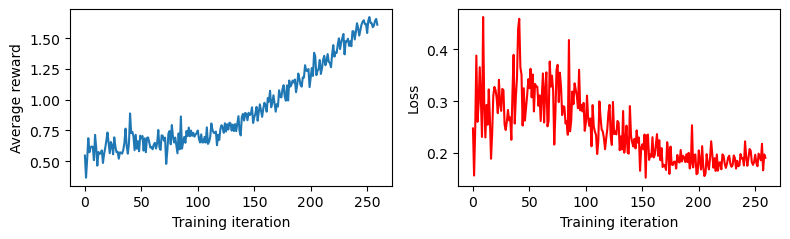

100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


Sample trajectories: 100
[6.930, 7.233, 6.978, 0.278, 0.462, 0.671]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=CC(C(F)(F)F)=C2)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[8.167, 8.670, 7.763, 1.568, 2.433, 1.723]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[6.644, 6.716, 6.455, 0.166, 0.189, 0.290]    CCCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C)=CC=C2C)S(C)(=O)=O
[7.311, 7.259, 7.422, 0.522, 0.481, 1.201]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(=O)(=O)C3=CC=CC=C3
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.145, 8.767, 8.059, 1.534, 2.610, 2.232]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[8.167, 8.670, 7.763, 1.568, 2.433, 1.723]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[8.145, 8.767, 8.059, 1.534, 2.610, 2.232]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C

[8.669, 8.237, 7.446, 2.431, 1.681, 1.235]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)COC2=CC(Cl)=CC(Cl)=C2CC(CCSC)C(=O)NC(CC3=CC=CC=C3)C(=O)NC
[7.431, 7.987, 7.370, 0.627, 1.294, 1.131]    CCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[7.480, 7.347, 7.321, 0.674, 0.551, 1.065]    O=C(NCCOC1=CC=CC=C1Cl)CC(=O)NC2CCCCC2N(CC3=CC=C(Cl)C=C3F)NC(=S)NC(=O)C(C)SC4=CC(Cl)=C(C)C=C4NS(C)(=O)=O
[8.775, 8.325, 7.984, 2.625, 1.825, 2.098]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.266, 6.873, 6.321, 1.727, 0.251, 0.229]    CNCCN(C(=S)NC1CC1N=CC(N=NC2=CC=CC=C2S)NCCC(N)=O)C(=O)NC(C(C)C)C(=O)NC(C)(C)C3=CC=C(F)C(F)=C3OCCN
[8.560, 7.812, 7.688, 2.233, 1.053, 1.601]    CNC(=O)C(C)N(CC1=CC=C(F)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=NC=C3Cl
[6.864, 7.059, 6.893, 0.247, 0.346, 0.591]    CCNC(SCC=NN=CSCC(=O

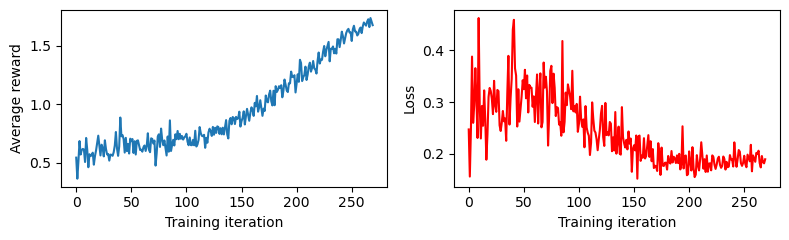

100%|██████████| 100/100 [00:07<00:00, 12.96it/s]


Sample trajectories: 100
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[8.167, 8.670, 7.763, 1.568, 2.433, 1.723]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[7.670, 8.398, 7.726, 0.878, 1.950, 1.662]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.711, 7.250, 7.018, 0.927, 0.474, 0.711]    CCNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.711, 8.010, 8.153, 2.506, 1.329, 2.401]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[7.004, 7.802, 7.968, 0.316, 1.040, 2.071]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC=C3C
[7.266, 7.099, 6.670, 0.486, 0.371, 0.416]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=CC(Br)=C2)C(=O)CN(C3=CC(Cl)=CC=C3Cl)S(C

[7.839, 7.644, 7.158, 1.089, 0.848, 0.864]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(C)(=O)=O
[6.355, 5.926, 5.073, 0.096, 0.042, 0.021]    CCN(CC)S(=O)(=O)C=CC=CC(NC(=S)NC(=O)C1=CC(Cl)=C(Br)C(Br)=C1N=CC)(F)CF
[8.115, 8.495, 7.199, 1.487, 2.118, 0.912]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[5.460, 5.545, 6.082, 0.017, 0.020, 0.148]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)C2N(C=C3C(C(=O)NC(C)C)C=CC=C)C=C32
[8.115, 8.495, 7.199, 1.487, 2.118, 0.912]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.736, 7.396, 7.031, 0.957, 0.595, 0.725]    O=CN1C(=O)N(C2=CC=C([N+1](=O)[O-1])C=C2)C(=O)C1=CC=CC(Cl)=C(NC=CC(Br)=CC3C)SC(C)=C3
[7.839, 7.644, 7.158, 1.089, 0.848, 0.864]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(C)(=O)=O
[7.361, 7.713, 7.643, 0.563, 0.929, 1.531]    CNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(Cl)C([N+1](=O)[O-1])=C3
[8.167, 8.670, 7.763, 1.568

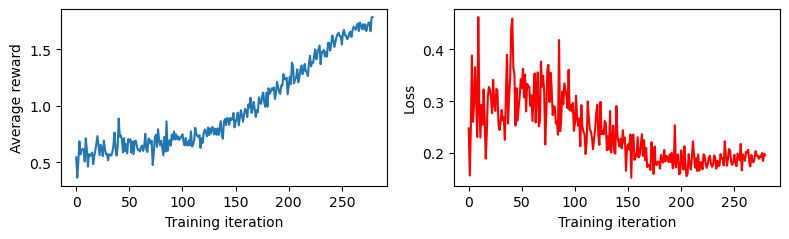

100%|██████████| 100/100 [00:07<00:00, 12.78it/s]


Sample trajectories: 100
[5.939, 5.535, 5.444, 0.043, 0.019, 0.044]    C1NN=CC(=N1)OC(=S)C(CNC(=S)NC(=O)CCC2CCCN2CC3=CC=CC=C3)NC(=O)C4=CC(Cl)=CC(Br)=C4CN(C)S(=O)(=O)C5=CC(Cl)=CC(Cl)=C5
[7.468, 8.273, 7.895, 0.662, 1.740, 1.944]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C)=CC=C2C)S(C)(=O)=O
[9.742, 8.974, 7.747, 4.494, 2.999, 1.697]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.993, 8.836, 7.636, 1.303, 2.739, 1.519]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(Cl)=CC(Cl)=C3
[6.903, 6.536, 6.584, 0.265, 0.136, 0.361]    COC(=O)CN1C(=S)N(C2=CC(Br)=C(OCC3=CC=C(F)C=C3)C(Cl)=C2C=S)N1C4=CC=C(Br)C(Br)=C4
[7.732, 7.013, 7.462, 0.951, 0.320, 1.258]    CNC(=O)C(C)N(CC1=CC=C(F)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=

[7.539, 7.453, 7.445, 0.733, 0.648, 1.235]    CCNC(=O)C(NC(=O)CSC=NN=C(NCCC1=CC=CC=C1C)C=CCS(=O)(=O)NC=CC(C2=CC(Cl)=CC=C2Cl)NCC3NC(=O)C4NC(=O)C(=CC5=CC=C(Br)S5C)CNS(=O)(=O)C6=CC=C7C(=C6)OCCO7)CC34N
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[7.226, 6.576, 7.097, 0.456, 0.146, 0.795]    CNC(=O)C(C)N(CC1=CC=CC(OC)=C1)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.167, 8.670, 7.763, 1.568, 2.433, 1.723]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[9.292, 8.064, 8.001, 3.611, 1.408, 2.128]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[8.899, 8.375, 8.093, 2.858, 1.910, 2.292]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.673, 8.679, 7.755, 2.438, 2.449, 1.710] 

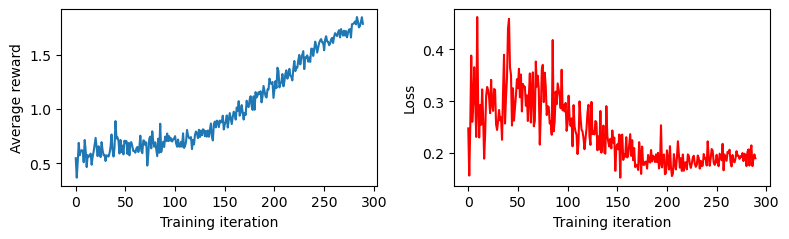

100%|██████████| 100/100 [00:07<00:00, 12.83it/s]


Sample trajectories: 100
[6.747, 6.966, 6.687, 0.200, 0.295, 0.428]    CNC(=O)C(C)NC(=O)CNC(=S)NC(C1=CC=CS1C2)=CC(Br)=CC=C2[NH1]C(=O)NCNC3=NC=C(S(=O)(=O)NC(C)C4=CC=CS4)SC=C3C5=CC=C(F)C([N+1](=O)[O-1])=C5
[5.468, 5.455, 5.769, 0.017, 0.017, 0.082]    CCNC(C1=CC=NC=O)=N1
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.899, 8.375, 8.093, 2.858, 1.910, 2.292]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[7.877, 7.918, 6.695, 1.140, 1.196, 0.434]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[5.635, 5.662, 5.515, 0.024, 0.025, 0.050]    C1NC(=O)C(C)N(CC2=CC3=C(Cl)C=C2Cl)C(=O)CN(C=C4C(Cl)=CC=C4)SC(=S)N31
[7.985, 8.077, 7.430, 1.292, 1.428, 1.212]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC=C3C
[8.869

[7.594, 8.182, 7.164, 0.791, 1.591, 0.870]    CNC(=O)C(C)N(CC1=C(Cl)C=CC=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.690, 7.956, 7.668, 0.901, 1.250, 1.569]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(Cl)=CC(Cl)=C3
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.869, 8.422, 8.082, 2.800, 1.991, 2.272]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.152, 8.218, 7.991, 1.543, 1.650, 2.111]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(Cl)=CC(Cl)=C3
[9.328, 8.999, 8.164, 3.682, 3.047, 2.422]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[7.669, 8.029, 7.484, 0.877, 1.356, 1.290]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Br)S(C)(=O)=O
[8.156, 8.365, 7.643, 1.551, 1.893, 1.530]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C

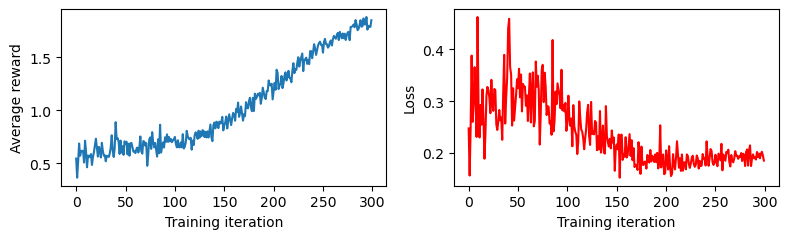

100%|██████████| 100/100 [00:07<00:00, 13.28it/s]


Sample trajectories: 100
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[9.090, 8.518, 7.601, 3.221, 2.159, 1.465]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(Cl)=CC=C3OC)S(=O)(=O)C4=CC(C)=CC(Br)=C4
[8.711, 8.010, 8.153, 2.506, 1.329, 2.401]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[5.169, 4.277, 4.704, 0.009, 0.002, 0.010]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC3=CC=C2C)C(=O)CN3C=CC([N+1](=O)[O-1])=CC=C
[8.156, 8.365, 7.643, 1.551, 1.893, 1.530]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1

[6.292, 5.779, 5.940, 0.086, 0.032, 0.113]    C1N(C=CC(C(F)(F)F)=CC(Br)=C1OCC(=O)NC2=CC(Cl)=CC(Cl)=C2)SC=NC(C)=CC(N3)=NC(C)(O)N=C3SC=C
[8.149, 7.396, 6.677, 1.539, 0.595, 0.421]    CNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(Cl)=CC=C3Cl)S(C)(=O)=O
[7.125, 7.841, 6.828, 0.387, 1.091, 0.535]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C)=CC=C2Cl)S(C)(=O)=O
[5.739, 5.046, 5.383, 0.029, 0.007, 0.039]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C=CC(C)=CC(C)=C
[8.042, 8.044, 7.617, 1.375, 1.378, 1.490]    CCCCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[7.990, 6.961, 5.910, 1.298, 0.293, 0.107]    C1CNN=CC[NH1]C(Cl)=CC(=O)C(C2=CC=CC=C2Br)=NN1C3=CC(C(F)(F)F)=CC=C3N4CCCCC4C(F)(F)F
[6.624, 6.628, 6.791, 0.160, 0.161, 0.506]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=C(Cl)C=C2Cl)S(C)(=O)=O
[5.729, 6.215, 6.675, 0.029, 0.074, 0.420]    C1N(CC2=CC(Cl)=C3C(Br)=C2NCCNSCC4=CC=C(Br)C=C4)CC5=CC=C(Br)C(Cl)=C5C(=O)CC31C

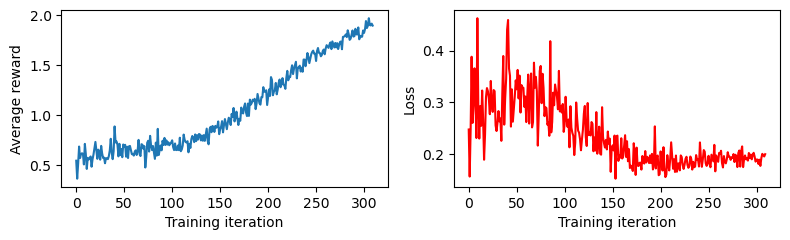

100%|██████████| 100/100 [00:06<00:00, 14.33it/s]


Sample trajectories: 100
[9.291, 8.170, 7.902, 3.609, 1.573, 1.956]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[7.444, 7.903, 7.361, 0.639, 1.175, 1.117]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.522, 8.159, 7.494, 2.165, 1.554, 1.304]    CCNC(=O)C(CC)N(CC1=CC=C(F)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.711, 8.010, 8.153, 2.506, 1.329, 2.401]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.012, 9.088, 7.982, 3.072, 3.216, 2.096]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[7.837, 7.349, 7.899, 1.086, 0.554, 1.951]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=C(Br)C=C3
[6.431, 6.722, 6.926, 0.111, 0.191, 0.622]    CCNC(=O)C(C)N(CC1=CC=C(F)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[6.486, 6.814, 5.612, 0.124, 0.226, 0.060]    CC1=CC(Br)=CC=C1NC(=O)NC

[8.896, 7.845, 7.954, 2.852, 1.096, 2.046]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[7.925, 8.199, 7.912, 1.207, 1.619, 1.974]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(Cl)=CC(Cl)=C3
[8.661, 7.864, 8.011, 2.415, 1.122, 2.147]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.156, 8.365, 7.643, 1.551, 1.893, 1.530]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[9.371, 7.740, 7.367, 3.766, 0.962, 1.126]    CNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[8.904, 7.848, 8.233, 2.867, 1.100, 2.548]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.012, 9.088, 7.982, 3.072, 3.216, 2.096]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C

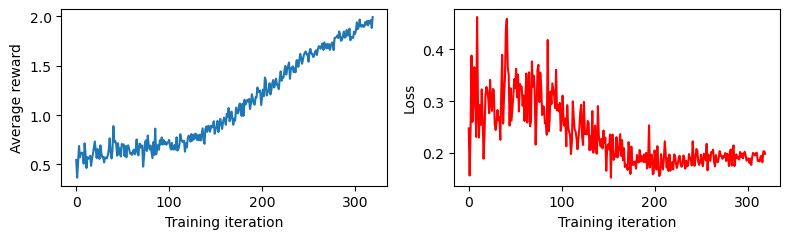

100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


Sample trajectories: 100
[7.127, 7.563, 7.743, 0.388, 0.758, 1.690]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(Cl)=CC(Cl)=C3
[8.711, 8.010, 8.153, 2.506, 1.329, 2.401]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.084, 8.265, 8.045, 3.209, 1.726, 2.206]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[8.711, 8.010, 8.153, 2.506, 1.329, 2.401]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.899, 8.375, 8.093, 2.858, 1.910, 2.292]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[9.084, 8.265, 8.045, 3.209, 1.726, 2.206]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC

[7.048, 7.048, 7.053, 0.340, 0.340, 0.748]    CCNC(SCC1=CC(=CC(Cl)=C1)NCCNC(=O)C=C2C(=NC3=CC=CC4=C23)NCC5=CC=C(Br)C=C5)C(C(=O)NC6=CC=CC=C6)=C(C)N4
[7.721, 7.186, 7.406, 0.939, 0.427, 1.180]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC=C(Cl)C(Cl)=C3
[7.877, 7.918, 6.695, 1.140, 1.196, 0.434]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.115, 8.495, 7.199, 1.487, 2.118, 0.912]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.493, 7.999, 7.938, 2.115, 1.312, 2.019]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[7.789, 8.333, 7.698, 1.023, 1.839, 1.618]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[

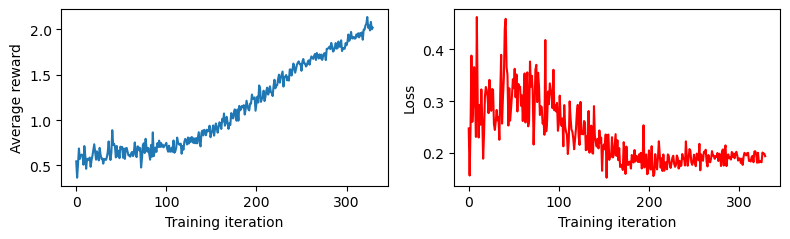

100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


Sample trajectories: 100
[8.588, 8.419, 7.586, 2.284, 1.986, 1.441]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[6.439, 6.452, 6.627, 0.113, 0.116, 0.388]    CC(C)NC(=O)C(C)N(CC1=CC=C(Br)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[8.418, 8.588, 7.961, 1.984, 2.283, 2.059]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.080, 7.570, 7.946, 1.433, 0.766, 2.032]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(Cl)=CC=C3OC
[6.128, 6.795, 6.472, 0.062, 0.218, 0.298]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC(Br)=C2)S(C)(=O)=O
[7.943, 7.887, 7.033, 1.232, 1.153, 0.727]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1F)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(C)(=O)=O
[8.775, 8.325, 7.984, 2.625, 1.825, 2.098]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[6.105, 5.379, 5.656, 0.060, 0.014, 0.066]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C

[9.742, 8.974, 7.747, 4.494, 2.999, 1.697]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.291, 8.170, 7.902, 3.609, 1.573, 1.956]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[7.979, 8.344, 6.416, 1.283, 1.857, 0.271]    CN(C)C(=O)C=CC(C(=O)NNC(=O)C(=CC1=CC(Br)=CC=C1OCC2=CC=C(Br)C=C2)SC=S)CCC=CC
[6.586, 6.953, 6.660, 0.149, 0.289, 0.410]    CCN(CC)C=CC=C(NC(=S1)NC(=O)CNC=CC(=O)NN=CC=CC(Br)=C(O)C(Br)=CC(=O)OC)CC2=CC(Cl)=CC(Br)=C2OC(OC)=C1OC
[9.118, 9.443, 8.157, 3.275, 3.906, 2.409]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[7.285, 7.244, 7.670, 0.501, 0.470, 1.573]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC=C3OC
[8.167, 8.670, 7.763, 1.568, 2.433, 1.723]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(C)(=O)=O
[8.899, 8.375, 8.093, 2.858, 1.910, 2.292]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=

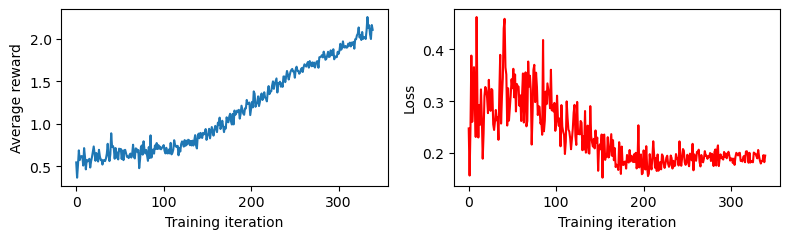

100%|██████████| 100/100 [00:07<00:00, 13.88it/s]


Sample trajectories: 100
[5.573, 5.419, 5.396, 0.021, 0.015, 0.040]    CNC(=O)C(N)CN(C(=O)CSC1=NN=C(SCC2=CC=C(F)C=C2)N1)C=CC3=CC(F)=CC(F)=C3[NH1]CC4=CC(OC)=CC(OC)=C4
[8.881, 7.851, 8.014, 2.823, 1.105, 2.152]    CNC(=O)C(C)N(CC1=CC=C(Cl)C(Cl)=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.105, 8.560, 7.705, 3.249, 2.233, 1.628]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[8.636, 9.234, 7.958, 2.371, 3.499, 2.053]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[6.232, 6.422, 5.231, 0.076, 0.110, 0.029]    COC=CC(C(=O)CC=C([NH1]C(=O)[NH1])ONC(CC(C)C)NC(=O)C(CC1=C2C=CC=C1)NC(=O)CCCOC)CNC(=O)C3CC(O)CN3C(=O)C(CC4=C[NH1]C5=CC=CC=C45)N2
[5.661, 5.317, 5.638, 0.025, 0.013, 0.064]    ClC=CC(NC(=S)NC(NC(=O)C1=CC(Br)=CC=C1)Cl)=O
[5.774, 5.692, 6.096, 0.031, 0.027, 0.152]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)C2N(C=CC(C(F)(F)C)=C2S=O)C=O
[9.020, 8.235, 7.636, 3.087, 1.677, 1.520] 

[7.367, 7.289, 7.015, 0.569, 0.504, 0.708]    CCNC(=O)C(CC)N(CC(=O)N1CCCCC1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C=CC(Cl)=CS)CC(=O)O
[8.148, 8.443, 7.582, 1.538, 2.028, 1.435]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[6.467, 6.396, 6.567, 0.119, 0.104, 0.351]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OS)C=O
[8.904, 7.848, 8.233, 2.867, 1.100, 2.548]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.284, 8.456, 7.940, 3.596, 2.051, 2.022]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.328, 8.999, 8.164, 3.682, 3.047, 2.422]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.854, 8.652, 8.104, 2.773, 2.399, 2.312]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=NC(Cl)=CC(Cl)=C3F
[8.230, 8.512, 7.826, 1.668, 2.148, 1.828]    CCCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(

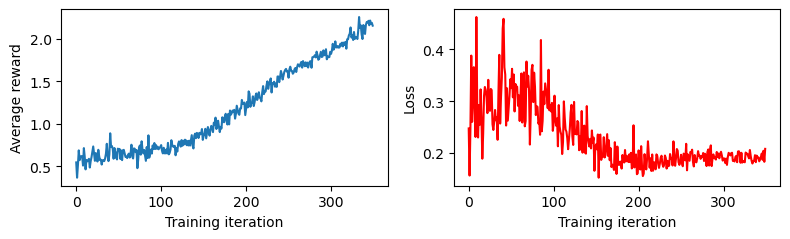

100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


Sample trajectories: 100
[9.012, 9.088, 7.982, 3.072, 3.216, 2.096]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.775, 8.325, 7.984, 2.625, 1.825, 2.098]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.894, 8.708, 7.519, 2.848, 2.501, 1.342]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(C(F)(F)F)=CC=C2Cl)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[9.367, 9.016, 7.794, 3.758, 3.078, 1.774]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[9.966, 8.357, 7.481, 4.938, 1.880, 1.286]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[8.443, 8.420, 8.016, 2.028, 1.987, 2.155]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.442, 7.224, 7.330, 2.025, 0.455, 1.077]    CNC(=O)C(C)N(CC1=CC=CC(C)=C1)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(F)=C3
[8.710, 8.460, 7.515, 2.504,

[9.012, 9.088, 7.982, 3.072, 3.216, 2.096]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.630, 8.685, 8.127, 2.360, 2.460, 2.353]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.912, 8.273, 8.031, 2.882, 1.739, 2.181]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.826, 7.665, 7.172, 2.721, 0.871, 0.879]    CCCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[7.866, 8.088, 8.034, 1.125, 1.445, 2.188]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC=C(Cl)C(Cl)=C3
[8.001, 8.643, 7.764, 1.315, 2.384, 1.725]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C(Cl)=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[8.998, 8.471, 7.438, 3.045, 2.076, 1.224]    CCCCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[7.170, 7.869, 7.430, 0.417, 1.128, 1.212]    CCC

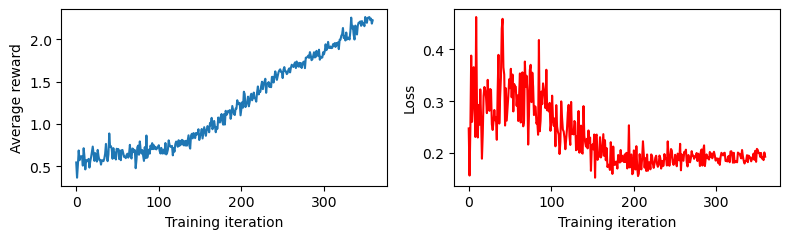

100%|██████████| 100/100 [00:07<00:00, 13.40it/s]


Sample trajectories: 100
[9.422, 8.082, 7.553, 3.865, 1.436, 1.392]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[7.417, 8.260, 7.693, 0.614, 1.718, 1.609]    CCNC(=O)C(C)N(CC1=CC=C(Br)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[9.742, 8.974, 7.747, 4.494, 2.999, 1.697]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[5.969, 6.300, 6.341, 0.046, 0.087, 0.237]    CCNC(=O)C1(CC)N(CC2=CC=C(Cl)C=C2C)C(=O)CCCN=CN=CN3N=C(C4=CC=C(Cl)C=C4)CC3(C)OC1(C)C
[9.606, 8.980, 7.554, 4.227, 3.011, 1.393]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.060, 8.361, 7.864, 3.163, 1.886, 1.891]    CCNC(=O)C(C)N(CC1=CC=CC(Cl)=C1)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.452, 8.996, 7.608, 3.925, 3.040, 1.475]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C(Cl)=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.012, 9.088, 7.982, 3.072, 3.216, 2.09

[7.037, 6.347, 5.610, 0.334, 0.095, 0.060]    C1NC(=O)C(CC)NC(=O)C(=CSC1(NC(=S)NC(=O)COC2=CC(Cl)=C(Cl)C=C2Cl)NC(=O)CN3)C(=O)C4=CC=CC=C4S3(=O)=O
[7.938, 7.558, 7.561, 1.224, 0.753, 1.404]    CCNC(=O)C(CC)N(CC1=CC=CC(OC)=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[4.285, 4.055, 4.211, 0.002, 0.001, 0.004]    O=CNC(=O)NC=CC(C)=C(Br)C(C)=C
[9.517, 8.632, 7.769, 4.052, 2.364, 1.733]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(F)=C3
[8.924, 8.668, 8.278, 2.904, 2.429, 2.630]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3
[7.915, 8.701, 7.815, 1.192, 2.489, 1.809]    CCNC(=O)C(CC)N(CC1=CC=C(Br)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[7.213, 8.219, 6.806, 0.447, 1.651, 0.517]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C=C(C)N(C)N(C3=CC=CC=C3)C=O
[7.677, 7.883, 6.927, 0.886, 1.148, 0.623]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=CC=C2

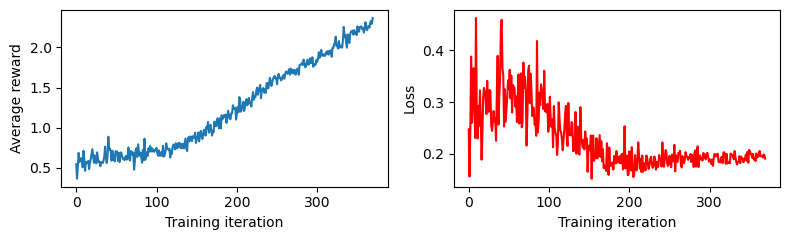

100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


Sample trajectories: 100
[9.606, 8.980, 7.554, 4.227, 3.011, 1.393]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(F)=C3
[5.740, 5.965, 6.245, 0.029, 0.045, 0.200]    C1C=CC=C1S(=O)(=O)NC(=S)NCCN(C(=S)NC(=S)NCCNC=NC(Cl)=NC(=O)OC)CN=CN=C
[9.389, 9.034, 8.298, 3.800, 3.114, 2.667]    CCNC(=O)C(C)N(CC1=CC=C(Br)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.306, 8.465, 8.104, 1.794, 2.066, 2.313]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.904, 7.848, 8.233, 2.867, 1.100, 2.548]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.251, 9.282, 7.921, 3.532, 3.591, 1.989]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3
[7.979, 7.931, 8.057, 1.282, 1.214, 2.228]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC=C(Br)C(Cl)=C3
[9.365, 8.332, 7.156, 3.754, 1.837, 0.861]    CCNC(=O)C(CC)N(CC=C

[8.869, 8.422, 8.082, 2.800, 1.991, 2.272]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[9.715, 8.735, 7.484, 4.442, 2.551, 1.290]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.284, 8.456, 7.940, 3.596, 2.051, 2.022]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[8.241, 6.162, 6.439, 1.687, 0.067, 0.282]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C=CC(C)=CC(Br)=C
[8.630, 8.685, 8.127, 2.360, 2.460, 2.353]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.145, 8.767, 8.059, 1.534, 2.610, 2.232]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[9.118, 9.443, 8.157, 3.275, 3.906, 2.409]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.367, 9.016, 7.794, 3.758, 3.078, 1.774]    CCNC(=O)C(CC)N(

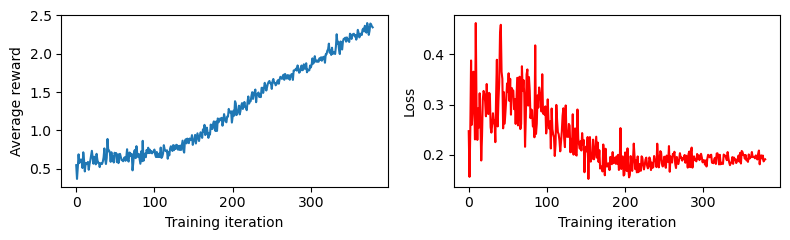

100%|██████████| 100/100 [00:07<00:00, 13.69it/s]


Sample trajectories: 100
[9.819, 8.939, 7.667, 4.648, 2.933, 1.568]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.394, 8.585, 7.573, 3.810, 2.277, 1.422]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1F)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[8.041, 6.481, 6.305, 1.374, 0.123, 0.222]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C=CC(Cl)=CC(Br)C=C)S(=O)(=O)C2=CC(C)=CC(F)=C2
[9.715, 8.735, 7.484, 4.442, 2.551, 1.290]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.071, 7.983, 7.290, 5.148, 1.288, 1.025]    CNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[8.339, 8.266, 8.103, 1.850, 1.728, 2.310]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.517, 8.596, 7.920, 2.157, 2.297, 1.988]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(Cl)=CC=C3Cl)S(=O)(=O)C4=CC(C)=CC(F)=C4F
[8.272, 6.745, 6.618, 1.737, 0.200,

[9.114, 8.958, 7.925, 3.267, 2.968, 1.996]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[9.328, 8.999, 8.164, 3.682, 3.047, 2.422]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.450, 7.467, 7.832, 2.040, 0.660, 1.838]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(Br)C(Cl)=C3
[9.105, 8.560, 7.705, 3.249, 2.233, 1.628]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[9.291, 8.619, 7.614, 3.610, 2.339, 1.485]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.792, 8.691, 7.709, 4.595, 2.470, 1.635]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.367, 9.016, 7.794, 3.758, 3.078, 1.774]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[7.269, 7.754, 7.324, 0.488, 0.979, 1.068]    CCNC(=O)C(CC)N(CC=C1C=C(C

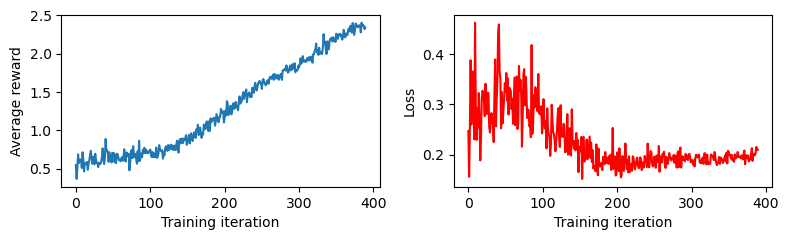

100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


Sample trajectories: 100
[9.289, 8.524, 7.925, 3.606, 2.170, 1.996]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(F)=C3
[8.001, 8.643, 7.764, 1.315, 2.384, 1.725]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C(Cl)=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[9.328, 8.999, 8.164, 3.682, 3.047, 2.422]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[6.122, 6.774, 6.206, 0.062, 0.210, 0.186]    CCNC(=O)C(CC)N(CC=CC(=O)NCCC)CCCNC(=O)C(C)NC(=O)C(C(C)C)NC(=O)C(=CC1=CC=C(Br)C=C1)NC(=S)NC2=CC=C(F)C(F)=C2F
[9.742, 8.974, 7.747, 4.494, 2.999, 1.697]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.371, 7.740, 7.367, 3.766, 0.962, 1.126]    CNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Br)=C3
[9.806, 8.804, 7.622, 4.621, 2.679, 1.497]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[8.785, 8.870

[5.689, 6.417, 6.285, 0.026, 0.109, 0.214]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=CC=C2)S(=O)(=O)C3C=NS(=O)(=O)C3C(F)(F)F
[9.806, 8.804, 7.622, 4.621, 2.679, 1.497]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.387, 8.618, 7.525, 5.776, 2.337, 1.350]    CCNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.387, 8.618, 7.525, 5.776, 2.337, 1.350]    CCNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.966, 8.357, 7.481, 4.938, 1.880, 1.286]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[8.924, 8.668, 8.278, 2.904, 2.429, 2.630]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.819, 8.939, 7.667, 4.648, 2.933, 1.568]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.570, 8.753, 7.899, 4.157, 2.584, 1.951]    CCNC(=O)C(CC)N(CC=C1C=

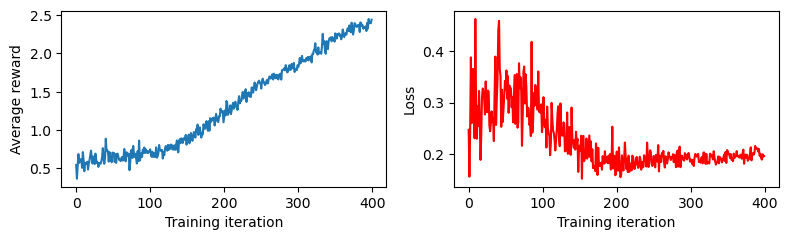

100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


Sample trajectories: 100
[10.091, 8.702, 7.766, 5.188, 2.490, 1.728]    CCNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.236, 8.070, 7.665, 3.503, 1.418, 1.565]    CNC(=O)C(C)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[9.037, 8.341, 7.714, 3.120, 1.852, 1.643]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1F)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.904, 7.848, 8.233, 2.867, 1.100, 2.548]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.278, 9.166, 7.897, 3.584, 3.367, 1.947]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[8.924, 8.668, 8.278, 2.904, 2.429, 2.630]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.512, 7.697, 7.016, 2.147, 0.909, 0.709]    CCNC(=O)C(C)N(CC=C1C=C(Cl)C=C1F)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.291, 8.619, 7.614, 3.610, 2.339, 1.485

[9.367, 9.016, 7.794, 3.758, 3.078, 1.774]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.424, 7.792, 7.392, 1.994, 1.027, 1.160]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C(Cl)=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.481, 9.020, 7.638, 3.980, 3.087, 1.522]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.363, 9.255, 8.113, 1.889, 3.539, 2.329]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[8.904, 7.848, 8.233, 2.867, 1.100, 2.548]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.278, 8.573, 7.718, 1.748, 2.256, 1.650]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=NC(C)=C3
[8.680, 8.993, 7.915, 2.451, 3.036, 1.980]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(Cl)=CC=C3Cl)S(=O)(=O)C4=CC(C)=CC(C)=C4
[8.148, 8.443, 7.582, 1.538, 2.028, 1.435]    

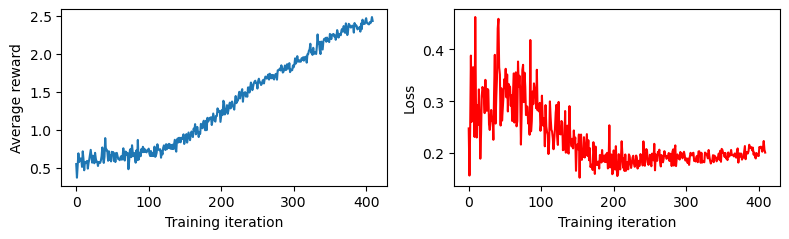

100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Sample trajectories: 100
[9.246, 8.215, 7.708, 3.522, 1.644, 1.633]    CCCNC(=O)C(C)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[8.145, 8.767, 8.059, 1.534, 2.610, 2.232]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[7.458, 7.631, 7.590, 0.652, 0.833, 1.449]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3C
[8.491, 9.059, 8.270, 2.111, 3.161, 2.616]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3C
[7.743, 8.269, 7.306, 0.965, 1.732, 1.045]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3CC
[9.481, 9.020, 7.638, 3.980, 3.087, 1.522]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[6.754, 5.424, 4.978, 0.203, 0.016, 0.017]    C1CNC(=O)C(CC2)N(CC=C3C=C(Cl)C(Cl)C)C3C(=O)CN(C4=CC(Cl)=CC=C4Cl)S(=O)(=O)C5=CC=NC=C5C1NCCC(C)CCN2
[8.869, 8.422, 8.082, 

[8.068, 7.764, 7.843, 1.414, 0.992, 1.856]    CCNC(=O)C(C)N(CC1=CC=CC(Br)=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.014, 9.245, 7.655, 3.075, 3.521, 1.548]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3Br
[9.481, 9.020, 7.638, 3.980, 3.087, 1.522]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.498, 8.741, 8.098, 4.014, 2.562, 2.302]    CCNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.631, 9.133, 7.749, 4.275, 3.304, 1.699]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[10.026, 8.054, 7.547, 5.059, 1.393, 1.383]    CNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[7.408, 8.267, 7.473, 0.605, 1.729, 1.275]    CCCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(C)(=O)=O
[7.073, 6.872, 6.149, 0.355, 0.251, 0.167]    C1CN(C)S(=O)(=O)C=NC1(NC(=S)

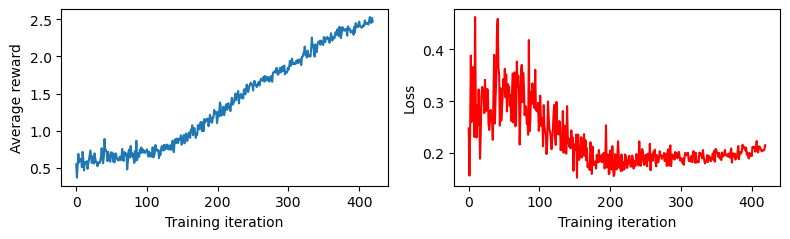

100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Sample trajectories: 100
[9.590, 8.828, 7.928, 4.196, 2.723, 2.001]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[8.761, 8.572, 7.756, 2.599, 2.254, 1.711]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[8.698, 8.706, 7.885, 2.483, 2.497, 1.928]    CCNC(=O)C(CC1=CC=CC=C1)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(Cl)=CC=C3OC)S(=O)(=O)C4=CC(C)=CC(F)=C4
[9.251, 9.282, 7.921, 3.532, 3.591, 1.989]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.590, 8.828, 7.928, 4.196, 2.723, 2.001]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[6.494, 6.270, 6.600, 0.125, 0.082, 0.371]    CCNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(O)=O
[9.715, 8.735, 7.484, 4.442, 2.551, 1.290]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[7.806, 6.247, 5.977, 1.045, 0.078, 0.122]    C1CNC(=O)C(

[9.553, 8.756, 7.565, 4.122, 2.589, 1.410]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[6.796, 6.940, 7.100, 0.219, 0.282, 0.799]    C1=2CNC(=O)C(CC)N(CC=C3C=C(Cl)C(Cl)C)C3C(=S)COC4=CC(C)=CC(C5)=C4C1C=2C=CN(C(=O)NC6CCCCC6)CNC7=CC(C8=CC=CS8)=NC7CCC5
[9.481, 9.020, 7.638, 3.980, 3.087, 1.522]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.058, 8.592, 7.951, 3.160, 2.291, 2.042]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[8.732, 8.335, 7.174, 2.546, 1.842, 0.883]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C=C3
[9.289, 8.524, 7.925, 3.606, 2.170, 1.996]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.570, 8.753, 7.899, 4.157, 2.584, 1.951]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[7.424, 8.090, 7.556, 0.620, 1.448, 1.397]   

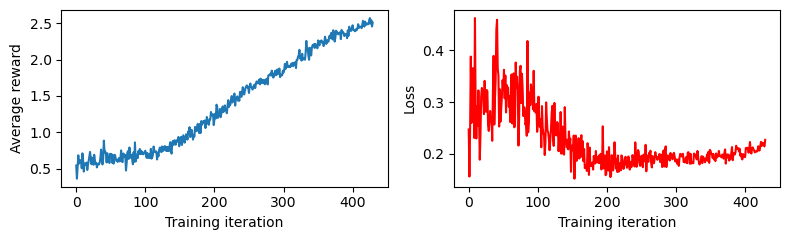

100%|██████████| 100/100 [00:08<00:00, 12.46it/s]


Sample trajectories: 100
[6.492, 6.873, 6.350, 0.125, 0.251, 0.241]    CCCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(C)(=O)=O
[6.537, 5.775, 5.777, 0.136, 0.031, 0.083]    C1CNC(=O)C(CC)N(CC2=CC=C(Cl)C=C2Cl)C(=O)CN(C3=CC(Cl)=CC=C3C)S(=O)(=O)C4=CC(C)=CC(C)=C4C=C1C
[8.320, 8.742, 7.214, 1.818, 2.565, 0.929]    CC=CC(C)=CC(N(CC(=O)N(CC1=CC=C(Cl)C=C1Cl)C(CC2=CC=CC=C2)C=O)NC3CCCCC3S(=O)(=O)C4)=CC=C(C)C([N+1](=O)[O-1])=C4C=CC(=O)NCCN(C(=O)CN(C5=CC(Cl)=CC(Cl)=C5Br)OCN6N=NCC7=CC=C(Cl)C=N7)CC6C=C
[10.819, 8.994, 7.449, 6.640, 3.037, 1.240]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[8.234, 7.516, 6.920, 1.676, 0.709, 0.616]    CNC(=O)C(C)N(CC=C1C=C(F)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=C(Cl)C=C3Cl
[9.220, 8.856, 8.012, 3.471, 2.775, 2.147]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.966, 8.658, 7.146, 4.939, 2.411, 0.850]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=

[9.685, 8.564, 7.513, 4.382, 2.240, 1.333]    CCCNC(=O)C(CC)N(CC=C1C=C(F)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[7.339, 8.214, 7.419, 0.545, 1.642, 1.198]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C(Cl)=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=CC(Cl)=C3
[8.081, 7.333, 6.369, 1.434, 0.540, 0.249]    CNC(=O)C=C(CN(CC1=CC(F)=CC=C1Cl)NC(=S)NC=C2C(S(=O)(=O)N3CCOCC3)=CC4=C2N5C)COCC5CNC(=O)C6=CC=CC=C6NC(=O)COC7=CC(C)=CC(C)=C74
[10.137, 8.857, 6.845, 5.280, 2.777, 0.550]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3C
[6.580, 7.225, 7.168, 0.148, 0.455, 0.875]    CCNC(=O)C(C1=CC=CC(Cl)=C1N2)(C=CC(S(=O)(=O)N)C3=CC(Cl)=CC(Br)=C3NC)CC(S(=O)(=O)N(CC)CC)=CC=CC=C2
[9.570, 8.753, 7.899, 4.157, 2.584, 1.951]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[8.289, 8.864, 7.980, 1.766, 2.791, 2.092]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(Cl)=C3C
[8.899, 8.375, 8.

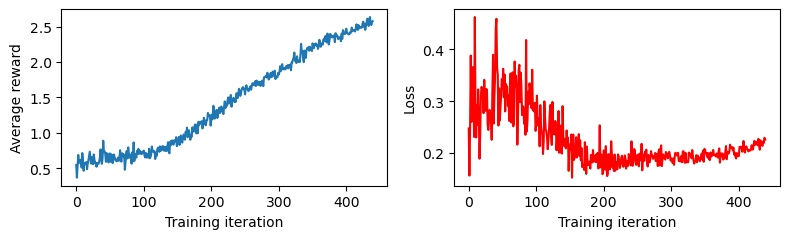

100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


Sample trajectories: 100
[9.404, 9.104, 8.160, 3.830, 3.247, 2.415]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3C
[7.196, 6.955, 7.635, 0.434, 0.290, 1.517]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC=CC=C2)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.742, 8.974, 7.747, 4.494, 2.999, 1.697]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[7.178, 6.433, 6.380, 0.422, 0.112, 0.254]    O=CC(=CC1=CC(Br)=CC(Br)=C1OCC(=O)NC2=CC(Cl)=C)C(Cl)=C2C3=CC(Cl)=C(Cl)C(Cl)=C3
[9.517, 8.632, 7.769, 4.052, 2.364, 1.733]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.606, 8.980, 7.554, 4.227, 3.011, 1.393]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.472, 7.943, 7.490, 3.963, 1.232, 1.299]    CNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[9.225, 8.843, 8.084, 3.482, 2.752, 2.275]    CCNC(=O)C(C)N(CC=C

[9.118, 9.443, 8.157, 3.275, 3.906, 2.409]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[10.640, 9.195, 7.196, 6.281, 3.423, 0.909]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(F)=C3C
[7.995, 8.747, 7.909, 1.306, 2.573, 1.968]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C=CC(C)(C)C3=CC(C)=CC(C)=C3F
[8.874, 8.748, 8.151, 2.811, 2.575, 2.398]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[5.037, 4.237, 4.921, 0.007, 0.001, 0.016]    CCNC(=O)C(NC(=O)CCC=O)OC(=O)CCNC(=O)C=CC=NC(C)=N
[8.188, 8.969, 7.867, 1.602, 2.989, 1.896]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C(Cl)=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[9.251, 9.282, 7.921, 3.532, 3.591, 1.989]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.220, 8.856, 8.012, 3.471, 2.775, 2.147]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C

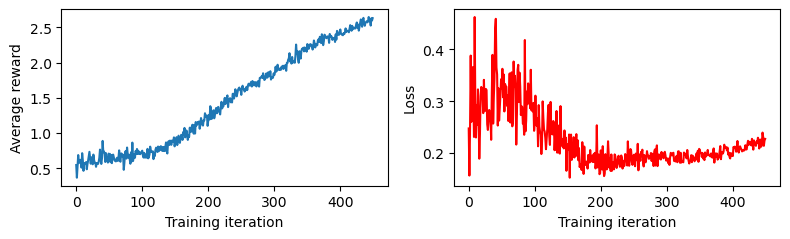

100%|██████████| 100/100 [00:07<00:00, 12.88it/s]


Sample trajectories: 100
[10.462, 8.768, 7.255, 5.927, 2.613, 0.980]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[8.452, 8.689, 8.302, 2.043, 2.467, 2.675]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3C
[10.026, 8.054, 7.547, 5.059, 1.393, 1.383]    CNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[8.496, 8.738, 8.129, 2.119, 2.556, 2.357]    CCCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.220, 8.856, 8.012, 3.471, 2.775, 2.147]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[8.390, 9.012, 8.005, 1.935, 3.071, 2.136]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3Br
[8.575, 8.954, 8.246, 2.259, 2.960, 2.572]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.265, 9.132, 7.976, 3.560, 3.302, 2.085]    

[9.351, 8.560, 7.641, 3.726, 2.233, 1.526]    CCNC(=O)C(CC)N(CCC1=CC=CC=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3C
[9.346, 8.800, 7.764, 3.717, 2.672, 1.725]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Br)=C3F
[10.819, 8.994, 7.449, 6.640, 3.037, 1.240]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[8.575, 8.954, 8.246, 2.259, 2.960, 2.572]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.606, 8.980, 7.554, 4.227, 3.011, 1.393]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.289, 8.524, 7.925, 3.606, 2.170, 1.996]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.715, 8.735, 7.484, 4.442, 2.551, 1.290]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.553, 8.756, 7.565, 4.122, 2.589, 1.410]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)

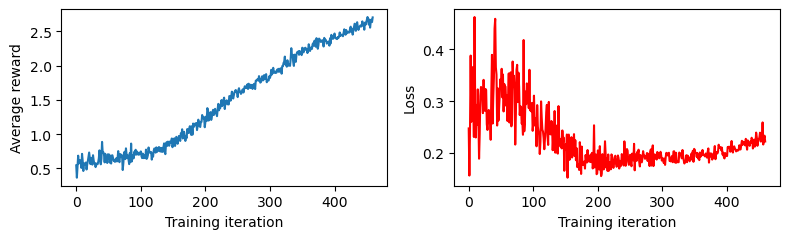

100%|██████████| 100/100 [00:07<00:00, 13.73it/s]


Sample trajectories: 100
[9.392, 9.002, 7.696, 3.807, 3.052, 1.614]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3Br
[9.570, 8.753, 7.899, 4.157, 2.584, 1.951]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.670, 9.033, 7.539, 6.342, 3.111, 1.371]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[8.465, 8.781, 8.229, 2.065, 2.636, 2.540]    CCNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3C
[9.759, 8.670, 7.518, 4.529, 2.432, 1.340]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.091, 8.702, 7.766, 5.188, 2.490, 1.728]    CCNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.328, 8.999, 8.164, 3.682, 3.047, 2.422]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[10.139, 8.250, 6.717, 5.283, 1.701, 0.450]

[7.205, 6.723, 7.021, 0.441, 0.192, 0.714]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2C)S(=O)(=O)C3=CC(C)=CC=C3Cl
[8.630, 8.685, 8.127, 2.360, 2.460, 2.353]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.327, 8.472, 7.877, 3.680, 2.078, 1.913]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.759, 8.670, 7.518, 4.529, 2.432, 1.340]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.391, 7.716, 7.036, 3.804, 0.933, 0.729]    CCNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C=C2C(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(F)=C3
[8.924, 8.655, 8.031, 2.903, 2.405, 2.182]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[10.334, 9.221, 8.233, 5.671, 3.474, 2.547]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3C
[9.498, 8.741, 8.098, 4.014, 2.562, 2.302]    CCNC(=O)C(C)N(CC=C1C=C(C

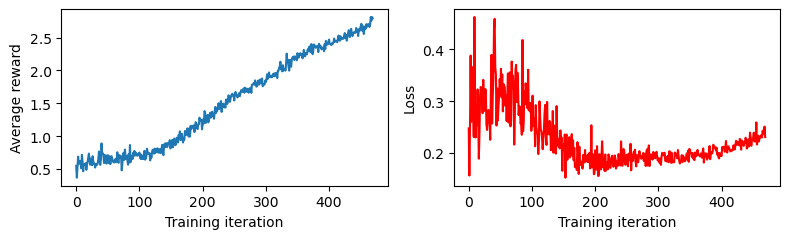

100%|██████████| 100/100 [00:08<00:00, 12.45it/s]


Sample trajectories: 100
[10.137, 8.857, 6.845, 5.280, 2.777, 0.550]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3C
[9.464, 9.183, 7.387, 3.947, 3.400, 1.154]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3Br
[8.890, 8.186, 7.002, 2.841, 1.597, 0.695]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3Cl
[9.273, 8.846, 7.830, 3.575, 2.758, 1.833]    CCNC(=O)C(CC1=CC=CC=C1)N(CC=C2C=C(Cl)C=C2Cl)C(=O)CN(C3=CC(Cl)=CC=C3OC)S(=O)(=O)C4=CC(C)=CC(F)=C4C
[10.334, 9.221, 8.233, 5.671, 3.474, 2.547]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3C
[10.645, 8.961, 7.530, 6.293, 2.975, 1.357]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.641, 8.116, 6.785, 4.295, 1.488, 0.501]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(C)=CC=C2C)S(=O)(=O)C3=CC(C)=CC(F)=C3
[9.570, 8.753, 7

[10.450, 9.112, 8.068, 5.903, 3.263, 2.247]    CCCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.257, 8.797, 7.766, 5.517, 2.665, 1.727]    CNC(=O)C(C)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3C
[8.443, 8.903, 8.148, 2.028, 2.864, 2.392]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3C
[9.328, 8.999, 8.164, 3.682, 3.047, 2.422]    CNC(=O)C(C)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[4.840, 4.525, 4.970, 0.005, 0.003, 0.017]    CCOC(=O)CNC(=O)SC(=CC=CN(CC(=O)NC1=CC(Cl)=CC=C1)Cl)CCl
[10.596, 9.158, 7.874, 6.194, 3.352, 1.908]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[7.631, 8.041, 6.272, 0.833, 1.374, 0.209]    CC1NCCN(S(=O)(=O)C=CC(C(=O)NCCN(CC(=O)NC2=CC(Cl)=CC(Cl)=C2)CC3CC)S(=O)(=O)C3)CC=C1
[9.806, 8.804, 7.622, 4.621, 2.679, 1.497]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=C

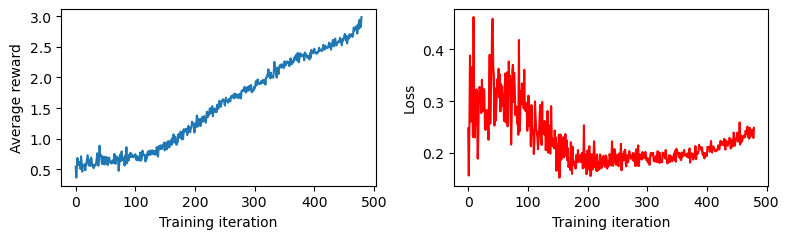

100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


Sample trajectories: 100
[10.494, 9.113, 8.109, 5.991, 3.265, 2.321]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.596, 9.158, 7.874, 6.194, 3.352, 1.908]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.634, 8.969, 7.417, 6.270, 2.990, 1.194]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3C
[10.645, 8.961, 7.530, 6.293, 2.975, 1.357]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[7.073, 6.567, 6.218, 0.355, 0.144, 0.190]    C1COC(=O)CNC(=O)C(SC=SC(F)(F)F)NN=NN=C(SCC2=CC=CC=C2Cl)N1
[8.761, 8.572, 7.756, 2.599, 2.254, 1.711]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C=C1C)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(Cl)=C3
[9.450, 8.649, 7.271, 3.921, 2.393, 1.001]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.911, 9.037, 8.289, 4.831, 3.118, 2.652]    CCNC(=O)

[8.594, 8.104, 7.060, 2.294, 1.470, 0.754]    CCNC(=O)C(CC)N(CCCC=CC(C)(C)C=C1C)C(=O)C2=CC(F)=CC(Br)=C2C1(O3)C(C)(C)C3C(=O)NCC4=CC=C(F)C(F)=C4
[10.334, 9.221, 8.233, 5.671, 3.474, 2.547]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3C
[10.596, 9.158, 7.874, 6.194, 3.352, 1.908]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[7.267, 6.220, 6.186, 0.487, 0.074, 0.179]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(C)=CC(C)=C2)S(=O)(=O)C=C(C)C(C)=CC(C)=C
[5.344, 4.620, 4.718, 0.013, 0.003, 0.010]    CCNC(=O)C(CC)NCC=C1C=C(Cl)C=N1
[7.328, 6.851, 5.996, 0.536, 0.242, 0.126]    CCCNC(=O)C(CC)N(C(=O)C1=CC=CC(Cl)=C1)C=CCN(C(=O)CC2=CC=C(Br)C=C2)C3CCCCC3N4CCN(C5=CC=CC=N5)CC4
[9.659, 9.235, 8.211, 4.331, 3.501, 2.508]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3F
[10.670, 9.033, 7.539, 6.342, 3.111, 1.371]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)C

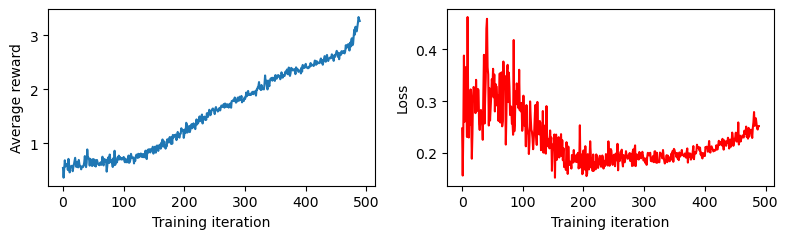

100%|██████████| 100/100 [00:07<00:00, 12.60it/s]


Sample trajectories: 100
[10.494, 9.113, 8.109, 5.991, 3.265, 2.321]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[7.430, 7.881, 7.110, 0.625, 1.146, 0.809]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC=CC(F)=C2)S(C)(=O)=O
[10.043, 8.756, 8.048, 5.092, 2.590, 2.212]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3
[9.600, 9.104, 8.135, 4.215, 3.248, 2.369]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C=C3C(C)=CC(F)=C3F
[10.596, 9.158, 7.874, 6.194, 3.352, 1.908]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.931, 9.020, 7.992, 4.870, 3.086, 2.114]    CCNC(=O)C(C)N(CC=C1C=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3C
[10.596, 9.158, 7.874, 6.194, 3.352, 1.908]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.963, 8.352, 7.204, 4.933, 1.872, 0

[10.819, 8.994, 7.449, 6.640, 3.037, 1.240]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.494, 9.113, 8.109, 5.991, 3.265, 2.321]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.494, 9.113, 8.109, 5.991, 3.265, 2.321]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.596, 9.158, 7.874, 6.194, 3.352, 1.908]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.596, 9.158, 7.874, 6.194, 3.352, 1.908]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.588, 9.381, 8.034, 6.179, 3.785, 2.186]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3C
[9.644, 8.843, 7.896, 4.301, 2.753, 1.946]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C=C3C(C)=CC(F)=C3F
[8.104, 7.332, 6.509, 1.469, 0.539, 

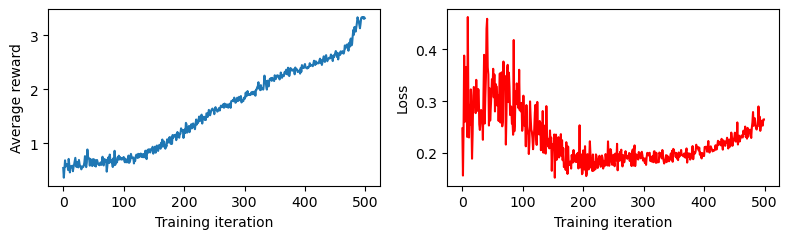

100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


Sample trajectories: 100
[10.494, 9.113, 8.109, 5.991, 3.265, 2.321]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[9.659, 9.235, 8.211, 4.331, 3.501, 2.508]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(C)=C3F
[10.596, 9.158, 7.874, 6.194, 3.352, 1.908]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.596, 9.158, 7.874, 6.194, 3.352, 1.908]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[6.191, 7.018, 6.399, 0.070, 0.323, 0.263]    CCCNC(=O)C(C(C)O)NC(=O)CN(C(=O)CC=CC(=O)N)C1C(C(=O)NCS2C(C)=C(C)N=C2CN=C(C)NCC)(C)C=C1CN(C)S(=O)(=O)C3=CC=C(C)C([N+1](=O)[O-1])=C3
[9.481, 9.020, 7.638, 3.980, 3.087, 1.522]    CCNC(=O)C(CC)N(CC1=CC=C(Cl)C=C1Cl)C(=O)CN(C2=CC(Cl)=CC=C2Cl)S(=O)(=O)C3=CC(C)=CC(C)=C3
[7.274, 6.522, 5.776, 0.492, 0.132, 0.083]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CCCN(C2=CC(Cl)(Cl)C=C2)Cl
[

[10.596, 9.158, 7.874, 6.194, 3.352, 1.908]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.494, 9.113, 8.109, 5.991, 3.265, 2.321]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.494, 9.113, 8.109, 5.991, 3.265, 2.321]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.819, 8.994, 7.449, 6.640, 3.037, 1.240]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C)C1C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[6.747, 7.304, 7.038, 0.200, 0.516, 0.732]    CCNC(=O)C(C1C)N(CC2=CC(Cl)=CC(Cl)=C2)S(=O)(=O)C3=CC(C)=CC(C)=C3CCN1CC4=CC=CO4
[10.170, 9.338, 8.074, 5.345, 3.701, 2.259]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Br)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3
[10.596, 9.158, 7.874, 6.194, 3.352, 1.908]    CCNC(=O)C(CC)N(CC=C1C=C(Cl)C(Cl)C=C1)C(=O)CN(C2=CC(Cl)=CC=C2OC)S(=O)(=O)C3=CC(C)=CC(F)=C3F
[10.819, 8.994, 7.449, 6.640, 3.037, 1.240]    CCN

In [22]:
tr_rewards = [] # rewards when training the model
rl_losses = [] # loss when training the model
reconst_losses = [] # reconstruction loss
entropy_losses = [] # entropy regularization

ba_A_list = []
ba_B_list = []
ba_C_list = []

execution_times = []

## Training RL optimizer
start_time = time.time()

alpha_min = 0.01
alpha_max = 0.05
alpha_inc = (alpha_max - alpha_min) / n_iterations
alpha = alpha_min
for i in range(1, n_iterations+1):
    ## policy gradient
    alpha += alpha_inc
    cur_reward, cur_loss, cur_reconst, cur_entropy = ReBADD.policy_gradient(n_batch=8, grad_clipping=1., alpha=alpha)
    
    ## append - reward
    #reward = simple_moving_average(tr_rewards, cur_reward)
    reward = cur_reward
    tr_rewards.append(reward)
    
    ## append - loss
    #rl_loss = simple_moving_average(rl_losses, cur_loss)
    rl_loss = cur_loss
    rl_losses.append(rl_loss)
    #reconst_loss = simple_moving_average(reconst_losses, cur_reconst)
    reconst_loss = cur_reconst
    reconst_losses.append(reconst_loss)
    #entropy_loss = simple_moving_average(entropy_losses, cur_entropy)
    entropy_loss = cur_entropy
    entropy_losses.append(entropy_loss)
        
    ## execution time check
    end_time = time.time()
    exec_time = end_time - start_time
    execution_times.append(exec_time)
    
    ## print - logs
    print(f"[{i:04d}] rl_loss: {rl_loss:.3f}\treconst_loss: {reconst_loss:.3f}\tentropy_loss: {entropy_loss:.3f}\treward: {reward:.3f}\ttau: {ReBADD.tau:.3f}\t({exec_time:.3f} sec)")
        
    ## checkpoint
    avg_ba_A = 0.
    avg_ba_B = 0.
    avg_ba_C = 0.
    if i % checkpoint_stepsize == 0:
        ## save
        ReBADD.generator.save_model(model_path.replace('.pth', f'.pth.{i:04d}'))
        
        ## plotting
        show_reward_loss(tr_rewards, rl_losses)

        ## sampling check
        smiles_cur = SMILES_generate(ReBADD, n_to_generate=100, gen_data=gen_data)
        print(f'Sample trajectories: {len(smiles_cur)}')
        if len(smiles_cur) > 0:
            for sm in smiles_cur:
                _, ba_A, ba_B, ba_C, score_A, score_B, score_C = my_reward_ft(sm, debug=True)
                print(f"[{ba_A:.3f}, {ba_B:.3f}, {ba_C:.3f}, {score_A:.3f}, {score_B:.3f}, {score_C:.3f}]    {sm}")
                avg_ba_A += ba_A
                avg_ba_B += ba_B
                avg_ba_C += ba_C
            avg_ba_A /= len(smiles_cur)
            avg_ba_B /= len(smiles_cur)
            avg_ba_C /= len(smiles_cur)
    
    ## append - binding affinity values
    ba_A_list.append(avg_ba_A)
    ba_B_list.append(avg_ba_B)
    ba_C_list.append(avg_ba_C)
    
    ## history save
    _ = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, losses_path)
    
    if i % behavior_stepsize == 0:
        ReBADD.update_behavior()

# 3. Save

In [23]:
ReBADD.generator.save_model(model_path)

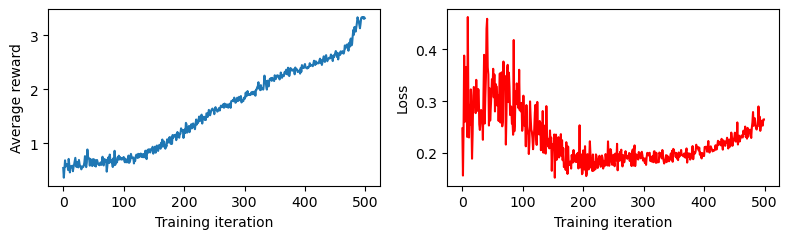

In [24]:
show_reward_loss(tr_rewards, rl_losses, filepath=plot_path)

In [25]:
df_history = write_history(tr_rewards, rl_losses, reconst_losses, entropy_losses, ba_A_list, ba_B_list, ba_C_list, execution_times, losses_path)
print(df_history.shape)
print(df_history.head())

(500, 8)
     REWARD      LOSS  LOSS_RECONST  LOSS_ENTROPY  BA_A  BA_B  BA_C  \
0  0.545349  0.247199      0.213005      0.034194   0.0   0.0   0.0   
1  0.365660  0.156165      0.121730      0.034434   0.0   0.0   0.0   
2  0.515018  0.247728      0.212761      0.034967   0.0   0.0   0.0   
3  0.686826  0.387958      0.353830      0.034128   0.0   0.0   0.0   
4  0.571978  0.259940      0.224889      0.035051   0.0   0.0   0.0   

    EXEC_TIME  
0   78.911397  
1  157.549316  
2  236.838314  
3  319.121607  
4  398.298254  


In [26]:
def save_smiles(filepath, smiles):
    with open(filepath, 'w') as fout:
        for smi in smiles:
            fout.write(f"{smi}\n")
    print(f"[INFO] {len(smiles)} SMILES were saved in {filepath}")

In [27]:
n_sampling = 30000

smi_after = SMILES_generate(ReBADD, n_sampling, gen_data)

100%|██████████| 30000/30000 [43:12<00:00, 11.57it/s]  


In [28]:
save_smiles(os.path.join(dataconfigs.output_dir, "smi_after.csv"), smi_after)

[INFO] 30000 SMILES were saved in outputs_2_optimize_ReBADD/zinc15/smi_after.csv
